In [108]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import IPython.display as ipd
import scipy
import math

import warnings
warnings.simplefilter("ignore")

### Erklärung der Domain-Begriffe
- Signal = Bewegung des Klangs in Form einer Schwingungsweite
- Sample Rate = Anzahl der Signals in einer Sekunde

In [130]:
files = [
    ["./data/BECKER-WIEDEMANN_Uli-2_short.wav", 29, 29 + 60], 
    ["./data/BECKER-WIEDEMANN_Uli-6_short.wav", 33, 33 + 60]
]

y_list = []
sr_list = []
cr_list = []

curve_occurence = [
    [[37], [41,42], [44,49], [50,51], [55], [57,60], [61,62], [63,68], [69,71], [72,75], [76,79], [80,81], [82], [83,88]],
    [[41], [45,46], [48,52], [54,55] ,[58,59], [61,63], [64,65], [67,71], [73,75], [76,79], [80,83], [84], [85], [88,92]]
]

def init_occurence_trans(list, ele, pos, start):
    def extend_dif_and_dur(list, ele, prev, pos):
        dif =  ele[0] - prev
        list.extend([0] * dif)
        if len(ele) == 1:
            list.append(pos)
        elif len(ele) == 2:
            dur = ele[1] - ele[0]
            dur = 2 if dur == 1 else dur
            list.extend([pos] * dur)
        return

    size = len(list)

    if size == 0:
        extend_dif_and_dur(list, ele, start, pos)
        return
    else:
        pre_val = size + start
        extend_dif_and_dur(list, ele, pre_val, pos)
        return

for ind in range(len(files)):
    file = files[ind]

    y_temp, sr_temp = librosa.load(file[0]) # y = waveform, sr = sample rate
    
    start = file[1] * sr_temp
    end = file[2] * sr_temp
    y_trans = y_temp[int(start) : int(end)] # Nur vom Beginn und Ende der Fahrt

    y_list.append(y_trans)
    sr_list.append(sr_temp)

    co = curve_occurence[ind]
    ls = []
    for cind in range(len(co)):
        init_occurence_trans(ls, co[cind], cind + 1, file[1])
    cr_list.append(np.asarray(ls))

print(f'Erste Fahrt => Länge des Klangs in Sekunden: {y_list[0].shape[0] / sr_list[0]}')
print(type(y_list[0]))
print(f'Zweite Fahrt => Länge des Klangs in Sekunden: {y_list[1].shape[0] / sr_list[1]}')

def execute_for_all(func):
    for ind in range(len(y_list)):
        print(f'function of {func.__name__} for dataset of index {ind}')
        func(y_list[ind], sr_list[ind], ind)

Erste Fahrt => Länge des Klangs in Sekunden: 60.0
<class 'numpy.ndarray'>
Zweite Fahrt => Länge des Klangs in Sekunden: 60.0


In [300]:
def min_max(ar):
    return np.max(ar) - np.min(ar) 

# e.g. range = 20 and measure = mean => mean of each 20 values
def transform_to_range_interval(arr, val_range, measure):
    res = []
    for pos in range(int(len(arr) / val_range)):
        start_pos = pos * val_range
        next_pos = start_pos + val_range
        res.append(measure(arr[start_pos : next_pos]))
    return np.array(res)

def transform_to_interval(f, interval, measure):
    res = []
    times = librosa.times_like(f)
    pos = interval
    pos_start_index = 0
    prev_index = 0

    for index in range(len(times)):
        time = times[index]
        
        if time > pos:
            prev_dif = np.abs(times[prev_index] - pos)
            curr_dif = np.abs(time - pos)
                
            if curr_dif > prev_dif:
                res.append(measure(f[pos_start_index:index]))
                pos_start_index = index
            else:
                res.append(measure(f[pos_start_index:index + 1]))
                pos_start_index = index + 1
            pos += interval

        if index + 1 == len(times):
            res.append(measure(f[pos_start_index:len(times)]))
        
        prev_index = index
    
    return np.array(res)

measures = [["mean", np.mean], ["min_max", min_max]]

In [192]:
def change_curve_bgcolor(cr, ax, interval, num_curve, snap = False):
    if (1 / interval % 1) > 0:
        raise ValueError(f'interval of {interval} is not accepted. e.g. 0,1, 0,25, 0,5...')

    cr_interval = np.repeat(cr, int(1 / interval))

    colors = ["white"]
    colors.extend(["mistyrose", "lightcyan"] * round(num_curve / 2))
    lcm = ListedColormap(colors)
    ax.pcolorfast(
        ax.get_xlim(), ax.get_ylim(),
        cr_interval[np.newaxis],
        cmap = lcm,
        snap = snap,
    )

### Waveform
- Ein Ansammelung von den Audio-Signalen
- Ergebnis mit den Datensätzen: Keine Phasen oder Beschleunigungen erkennbar.  

function of show_wave for dataset of index 0


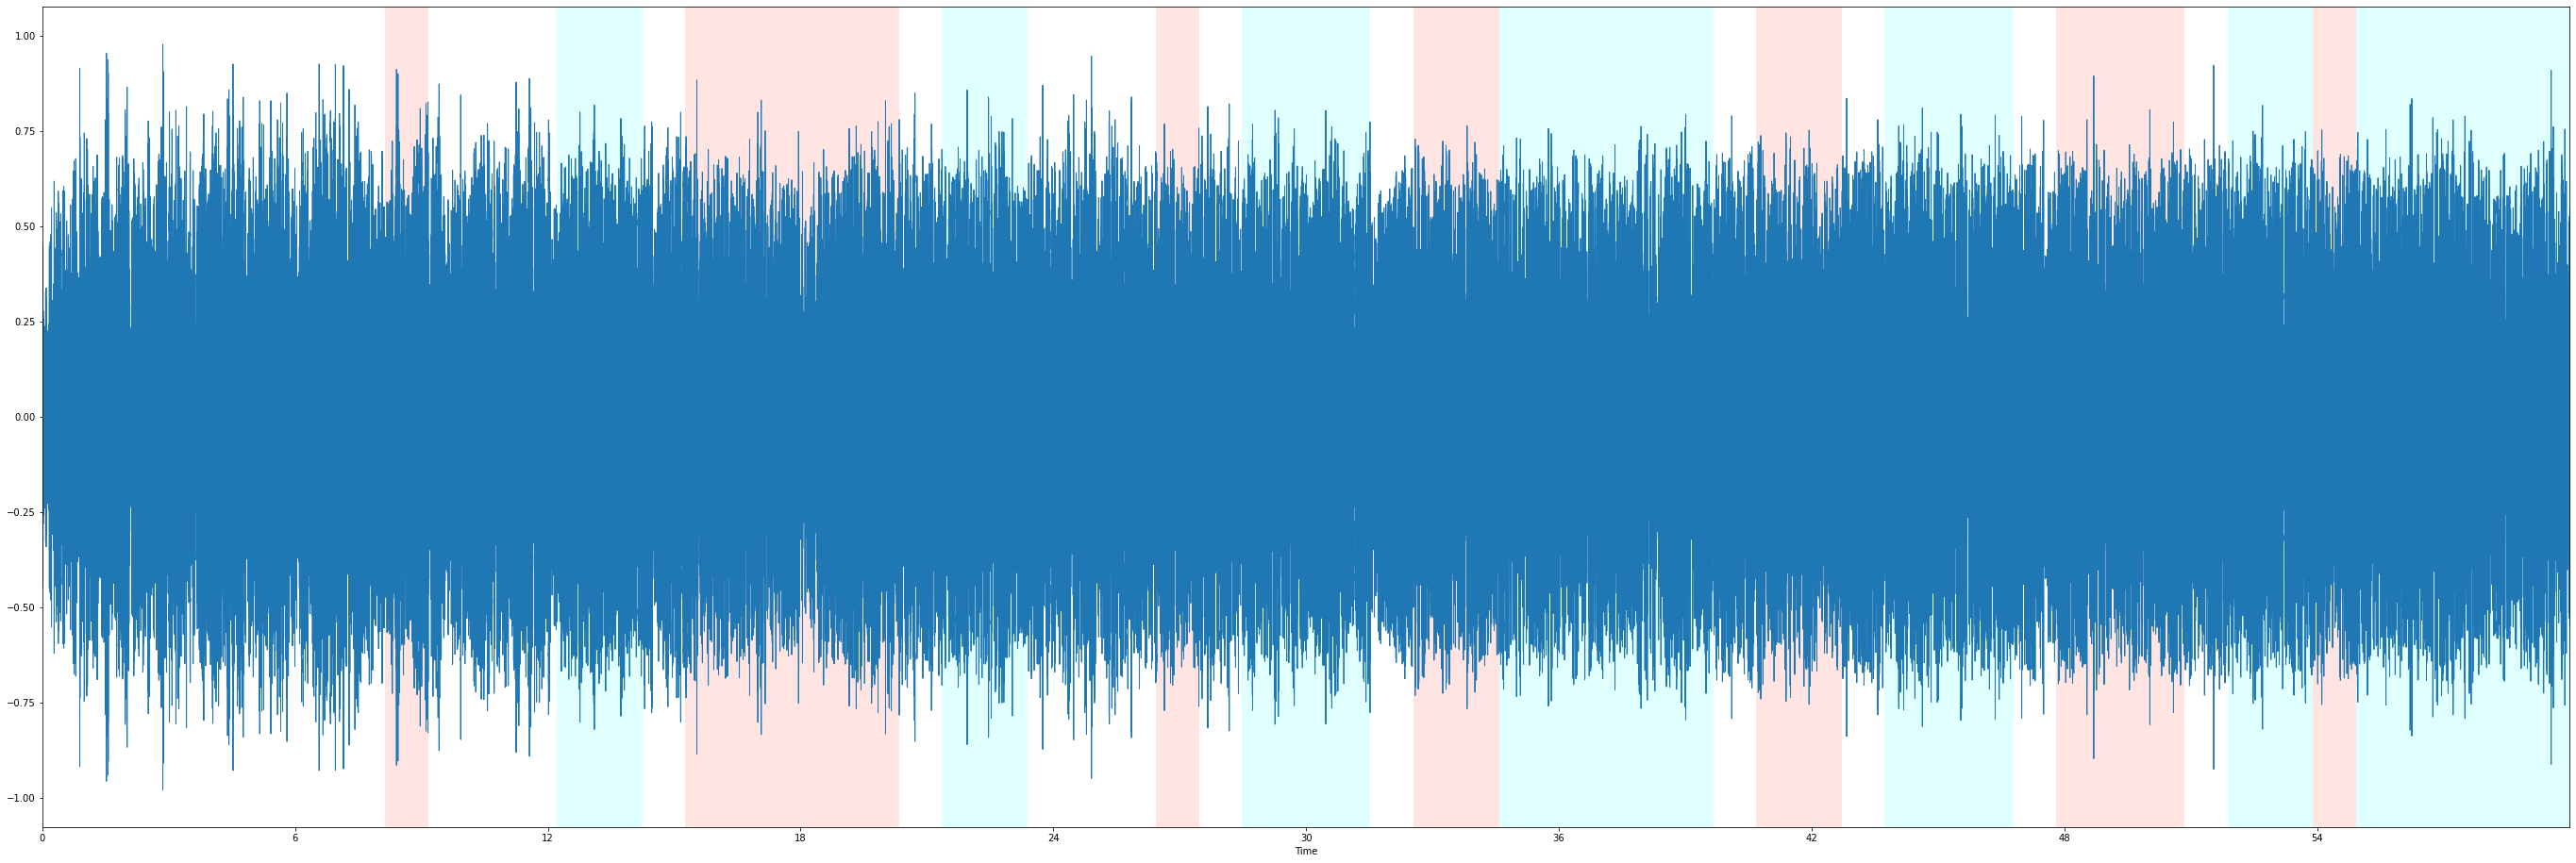

function of show_wave for dataset of index 1


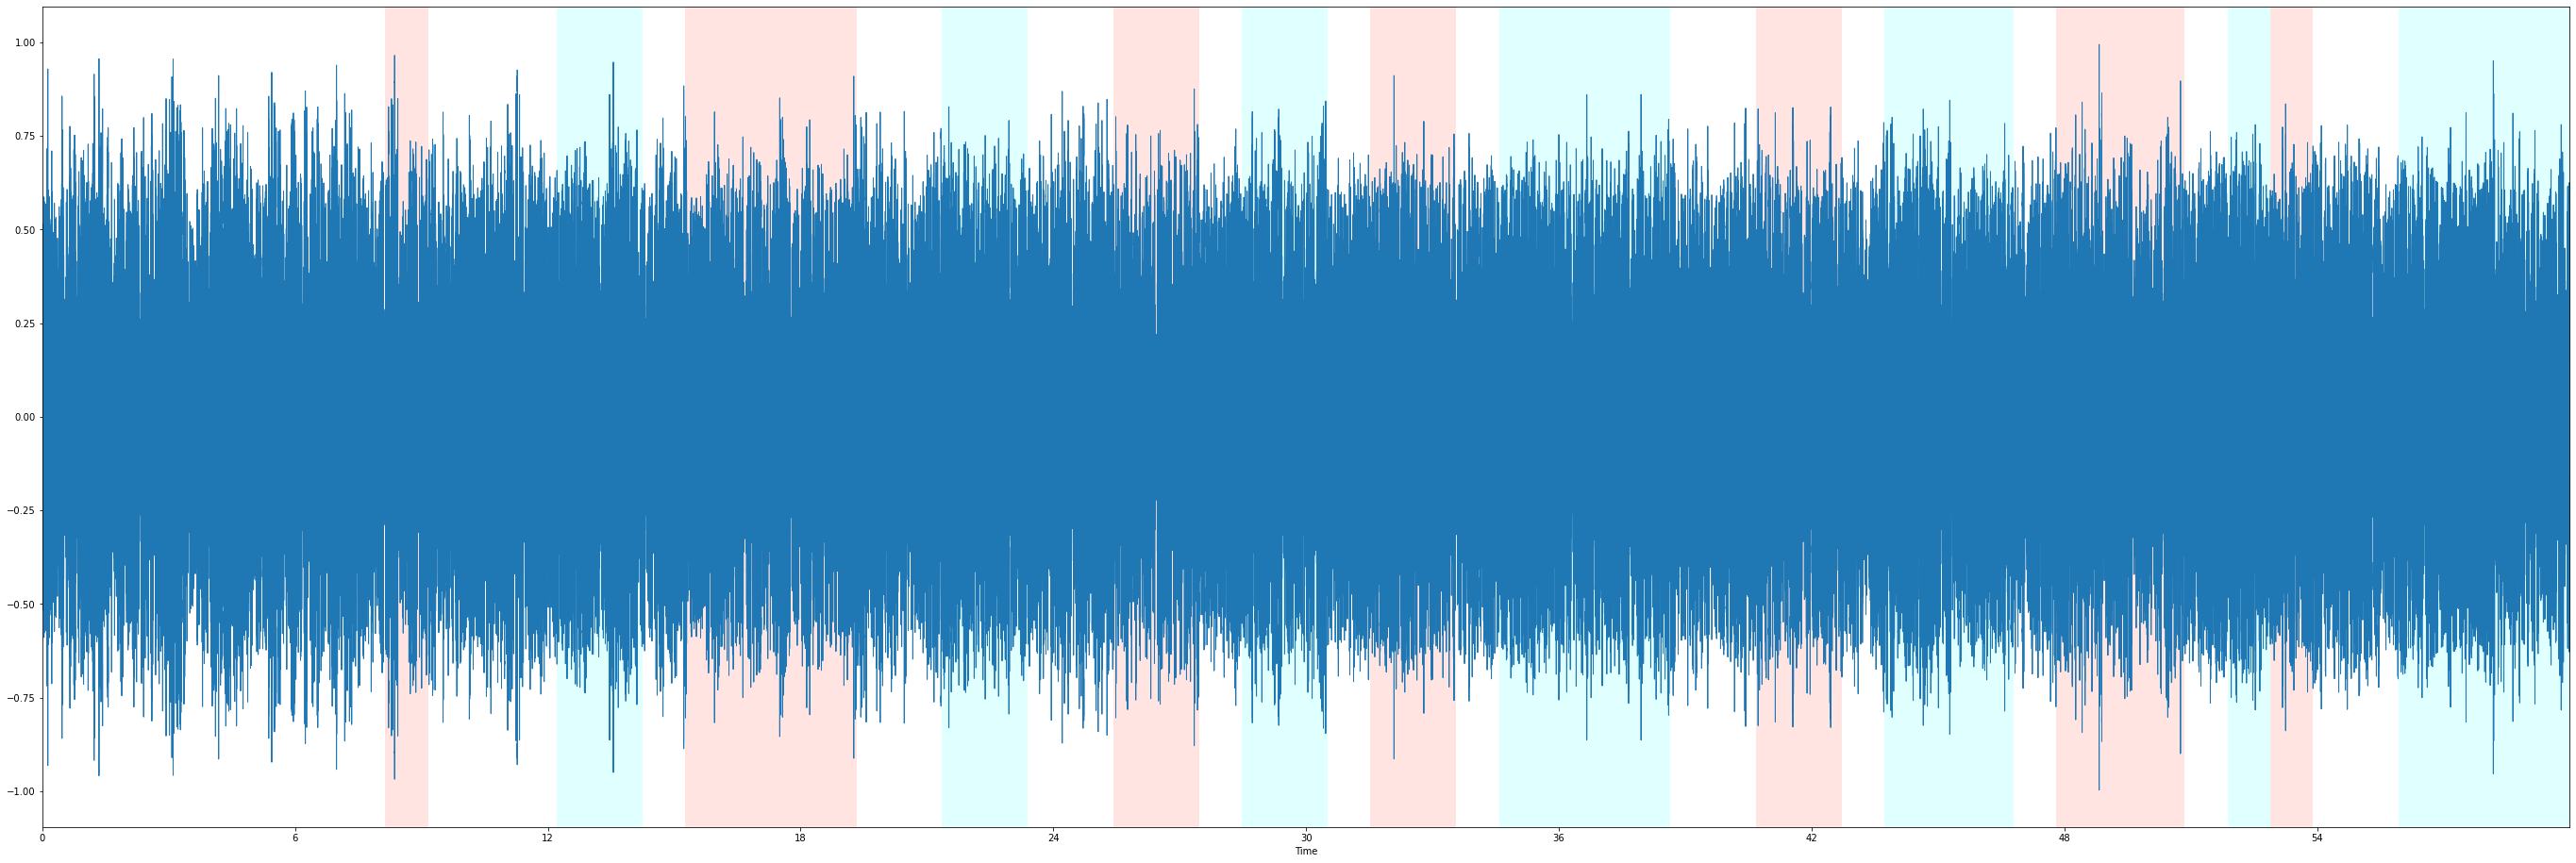

In [195]:
def show_wave(y, sr, ind):
    ax = plt.figure(figsize=(48, 16)).add_subplot()
    librosa.display.waveplot(y, sr=sr, ax = ax)
    change_curve_bgcolor(cr_list[ind], ax, 1, 14)
    plt.show()
execute_for_all(show_wave)

### Amplitude Evelope
- Extraktion det maximalen & minimalen Amplituden innerhalb einem Signal
- stellt somit den Wertumfang des Signals dar
- Detektion des On-set Klangs
- Wikipedia: https://en.wikipedia.org/wiki/Envelope_(waves)
- Ergebnis mit den Datensätzen: Die Formen der Welle zeigt die Differenz von Lautstärke des Klangs

![](./doc/1_iJlyQtukhlafuPkw8BaRxQ.png)

function of show_amplitude_evelope for dataset of index 0


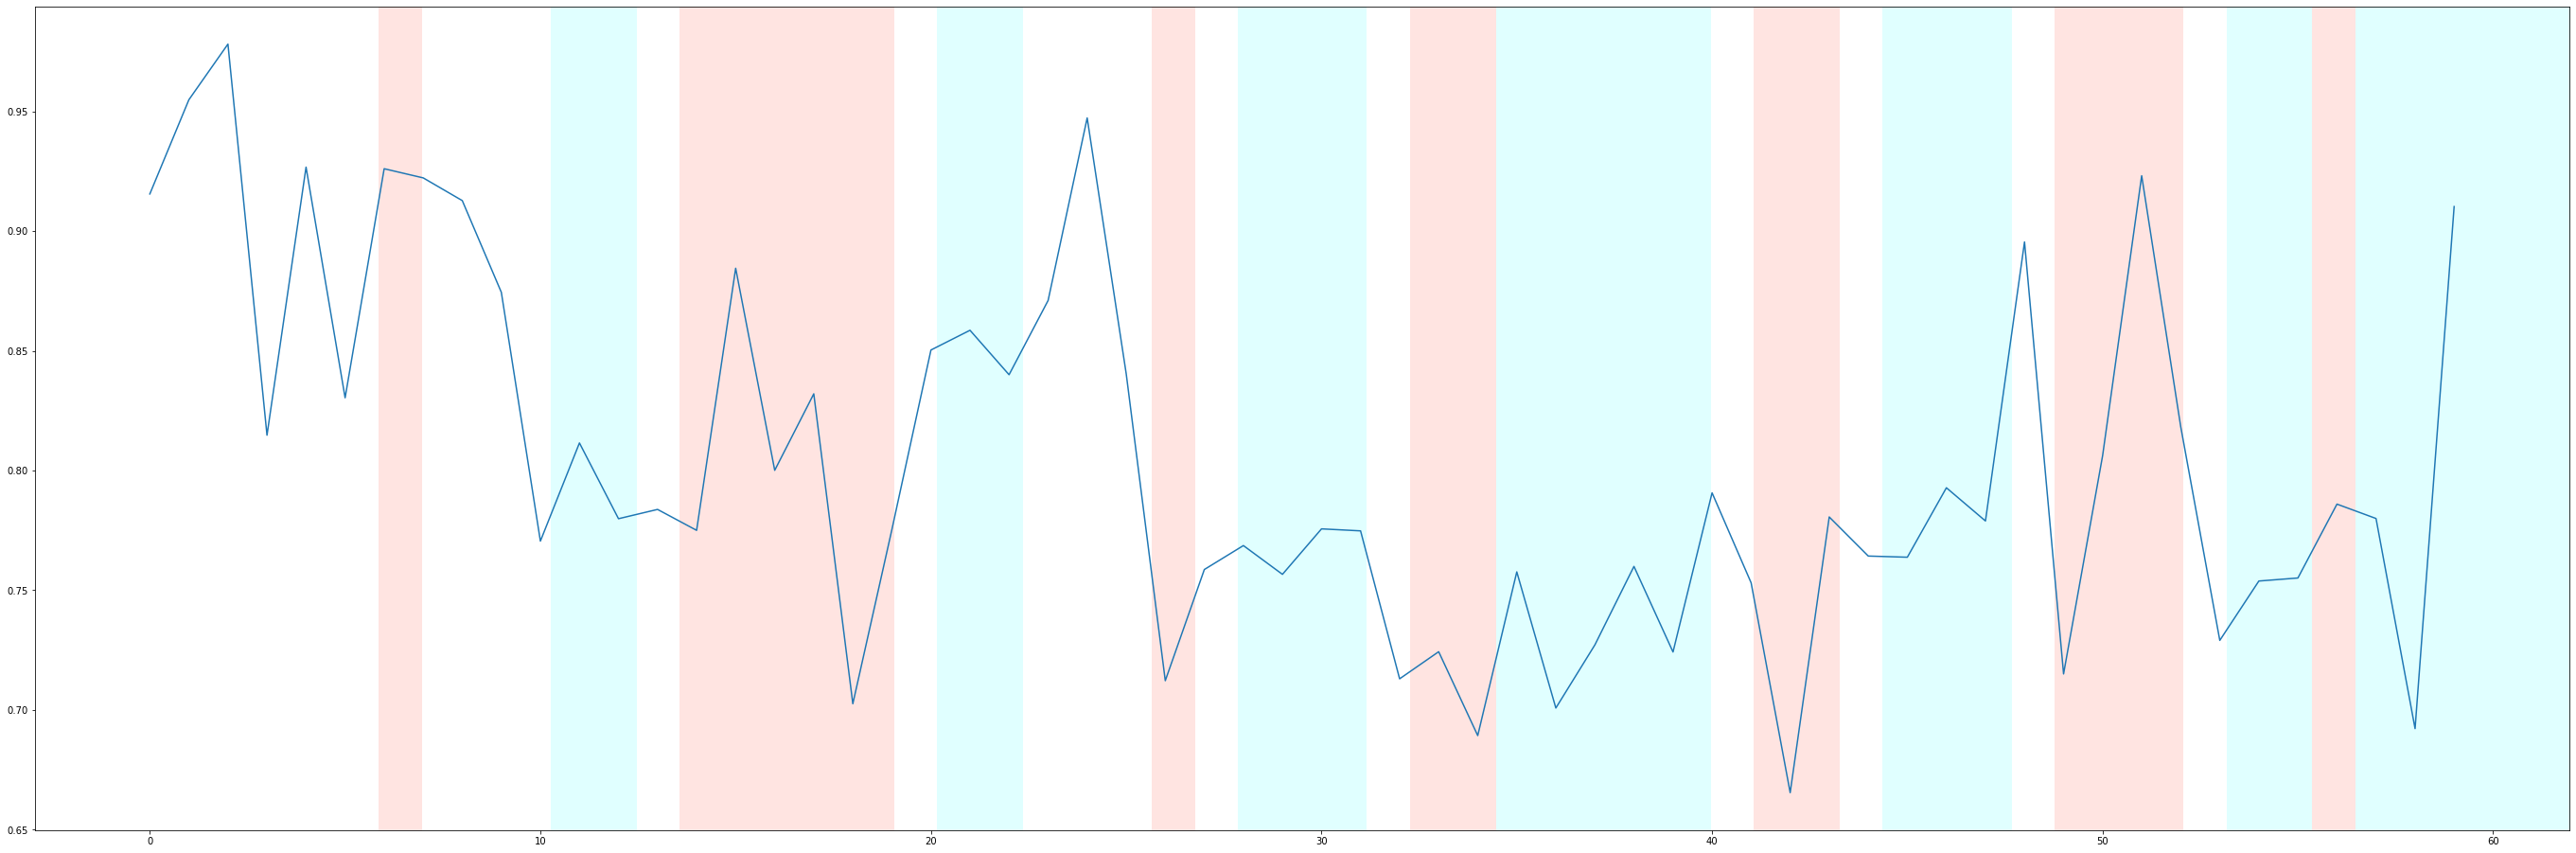

function of show_amplitude_evelope for dataset of index 1


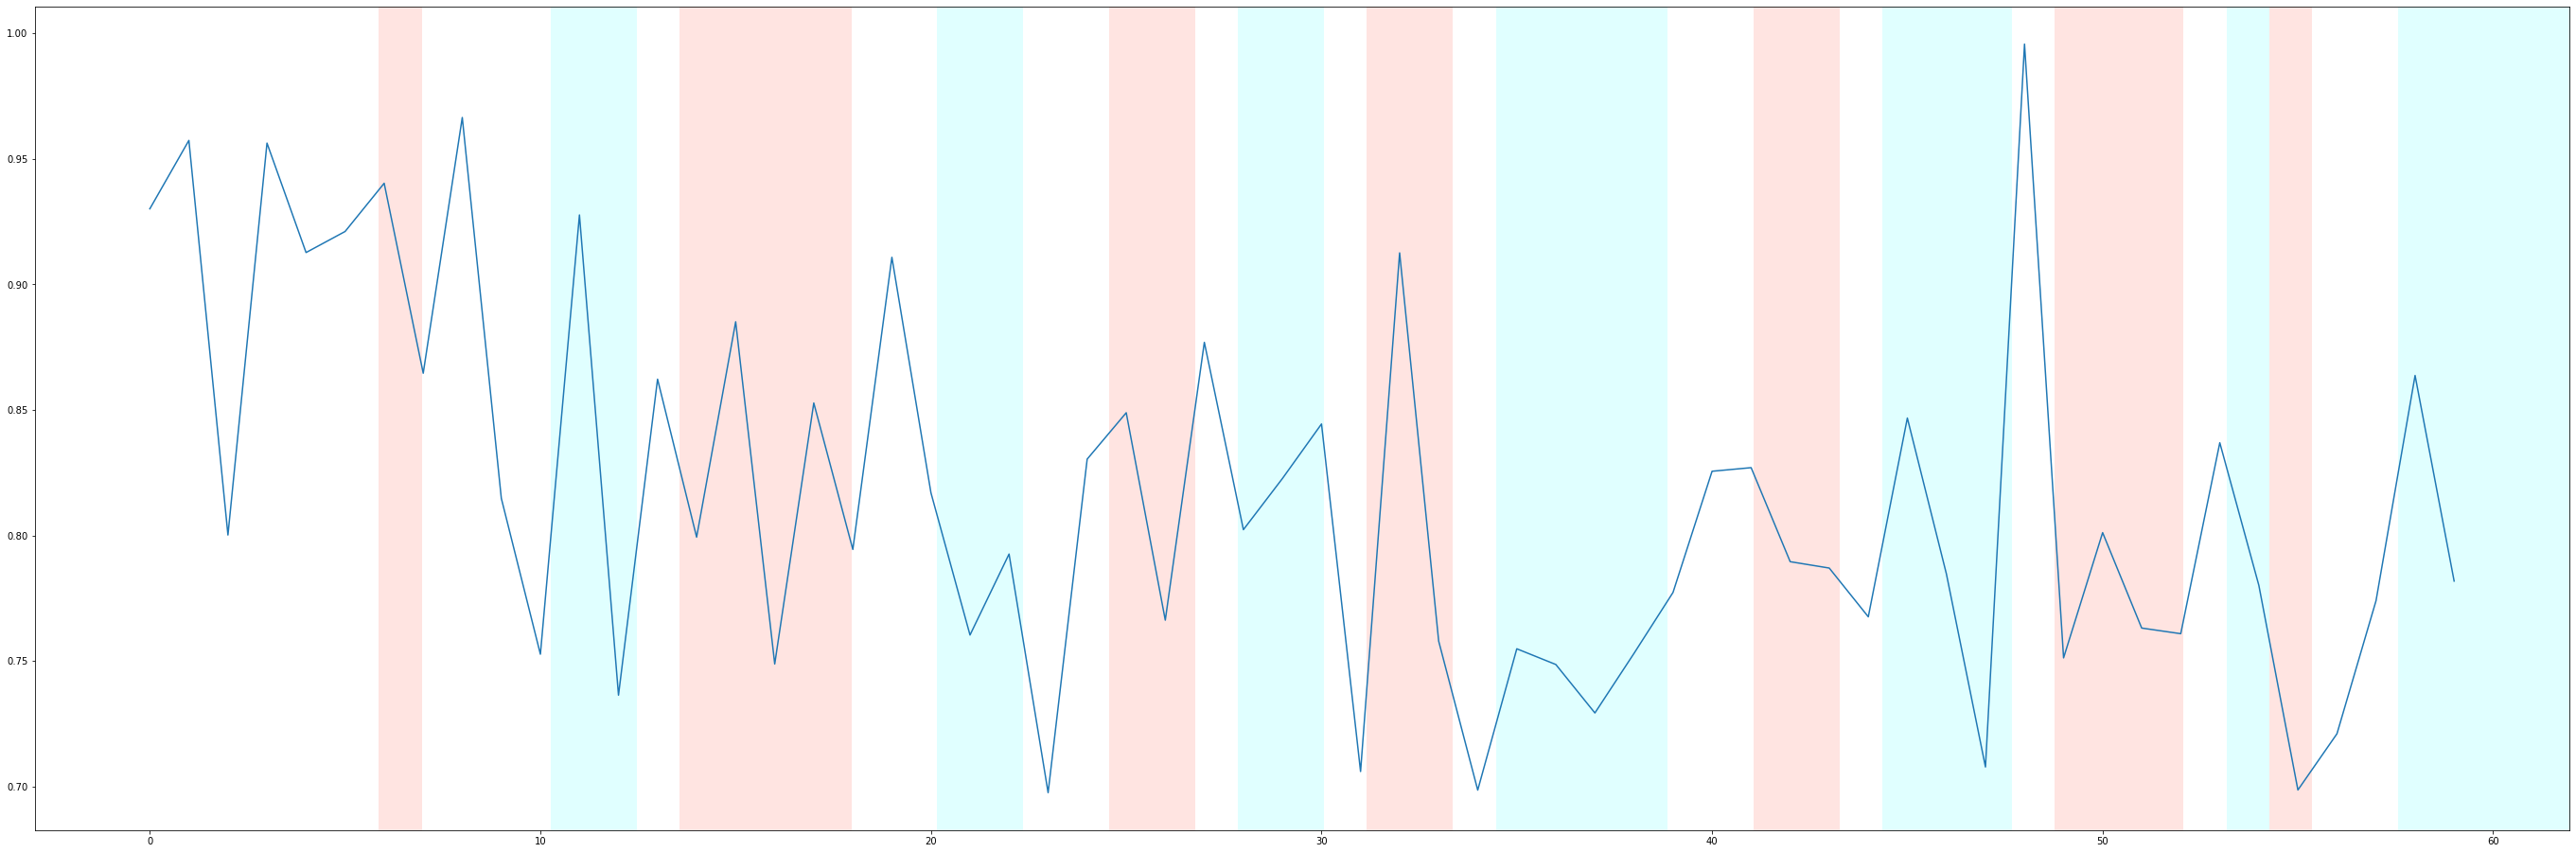

In [182]:
def show_amplitude_evelope(y, sr, ind):
    AE = []
    num_frames = math.floor(y.shape[0] / sr)
    for t in range(num_frames):
        lower = t*sr
        upper = (t+1)*(sr-1)
        AE.append(np.max(y[lower:upper]))
    res = np.array(AE)
    ax = plt.figure(figsize=(48, 16)).add_subplot()
    ax.plot(res)
    change_curve_bgcolor(cr_list[ind], ax, 1, 14)
    plt.show()

execute_for_all(show_amplitude_evelope)

### Root-Mean-Square (RMS) = quadratisches Mittel
- Nutzung des quadratischen Mittels anhand Amplitude Evelope
- Anders als Amplitude Evelope, welche den On-set Klang darstellt, wird anhand dieser Technik die Lautstärke des Klangs gezeigt.
- Ergebnis mit den Datensätzen: Kein Muster erkennbar


![](./doc/1_7M07bUsh3PDR4jfwUOm5CA.png)

function of show_RMS for dataset of index 0
Länge des RMS: 2584


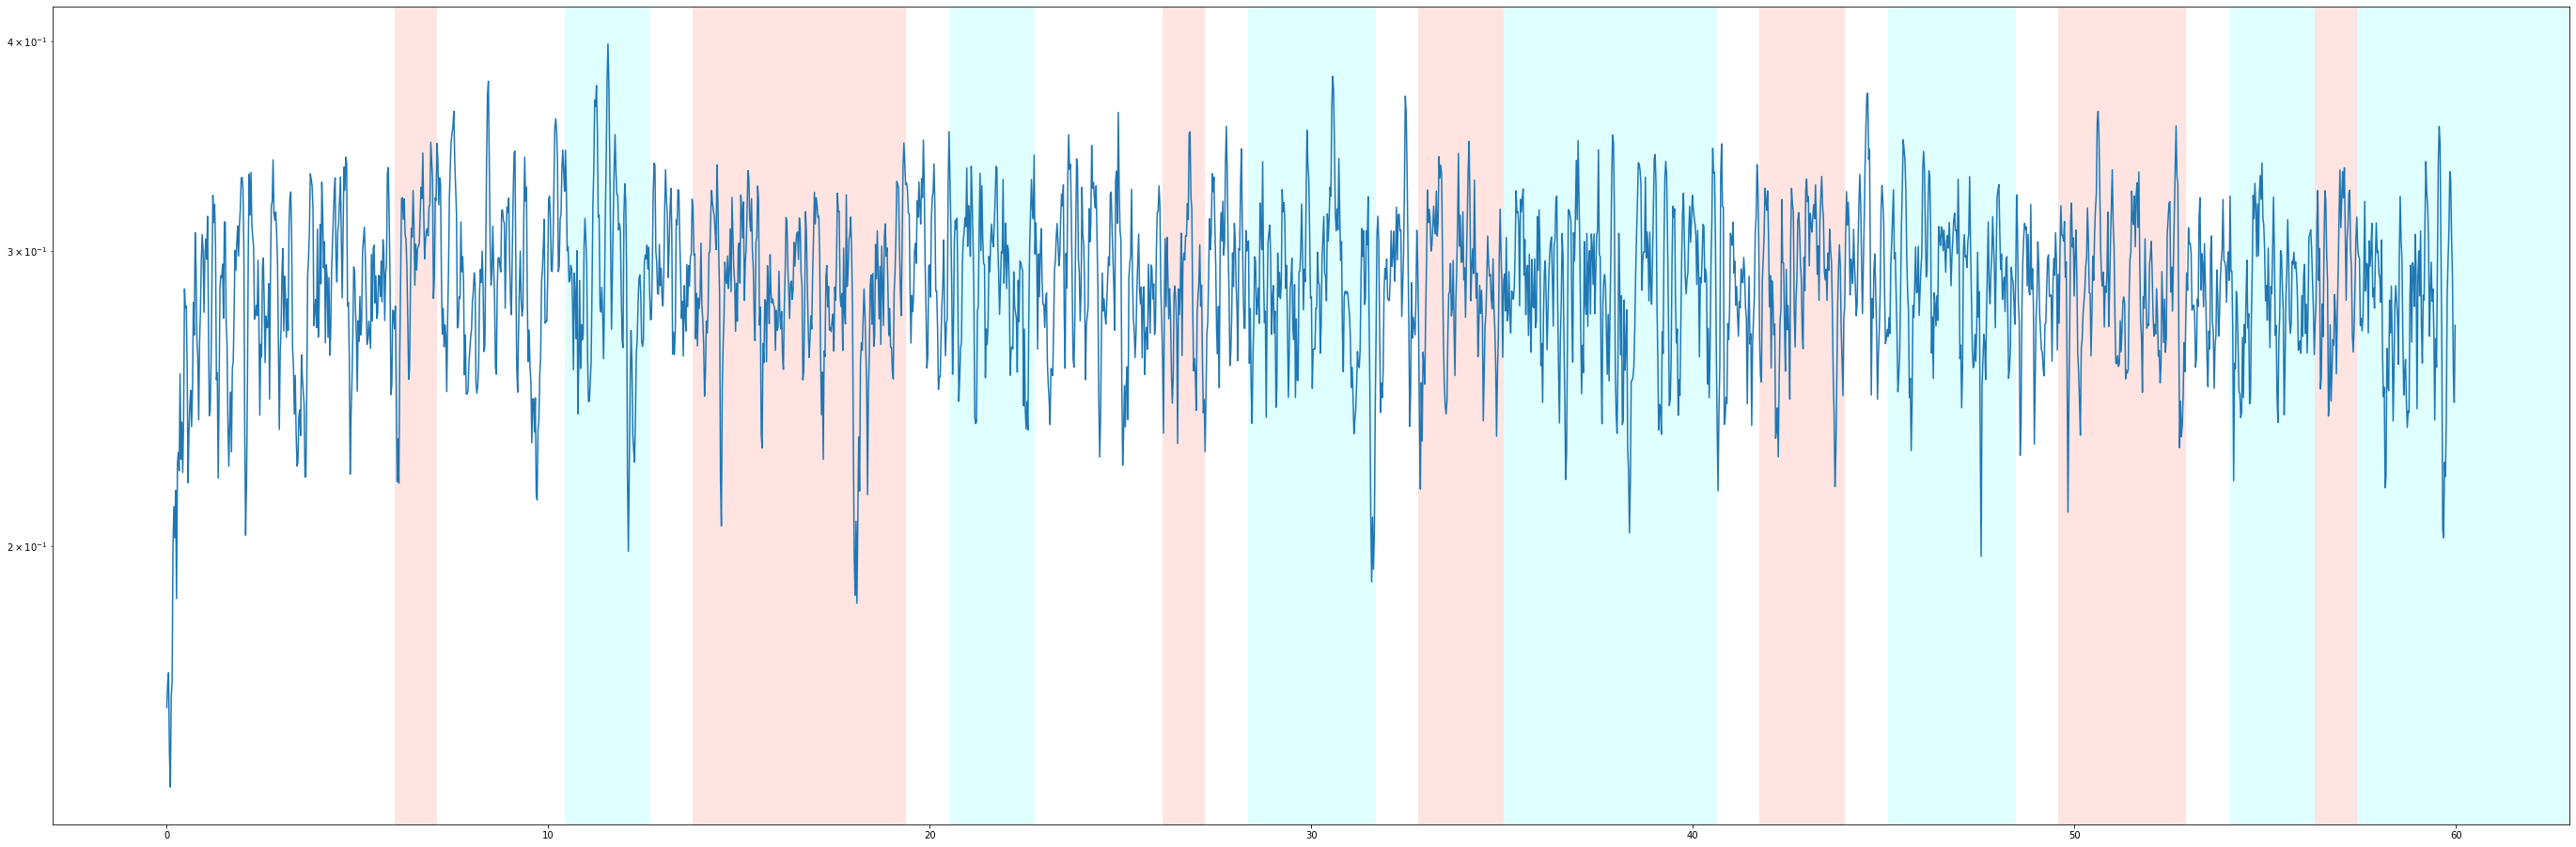

function of show_RMS for dataset of index 1
Länge des RMS: 2584


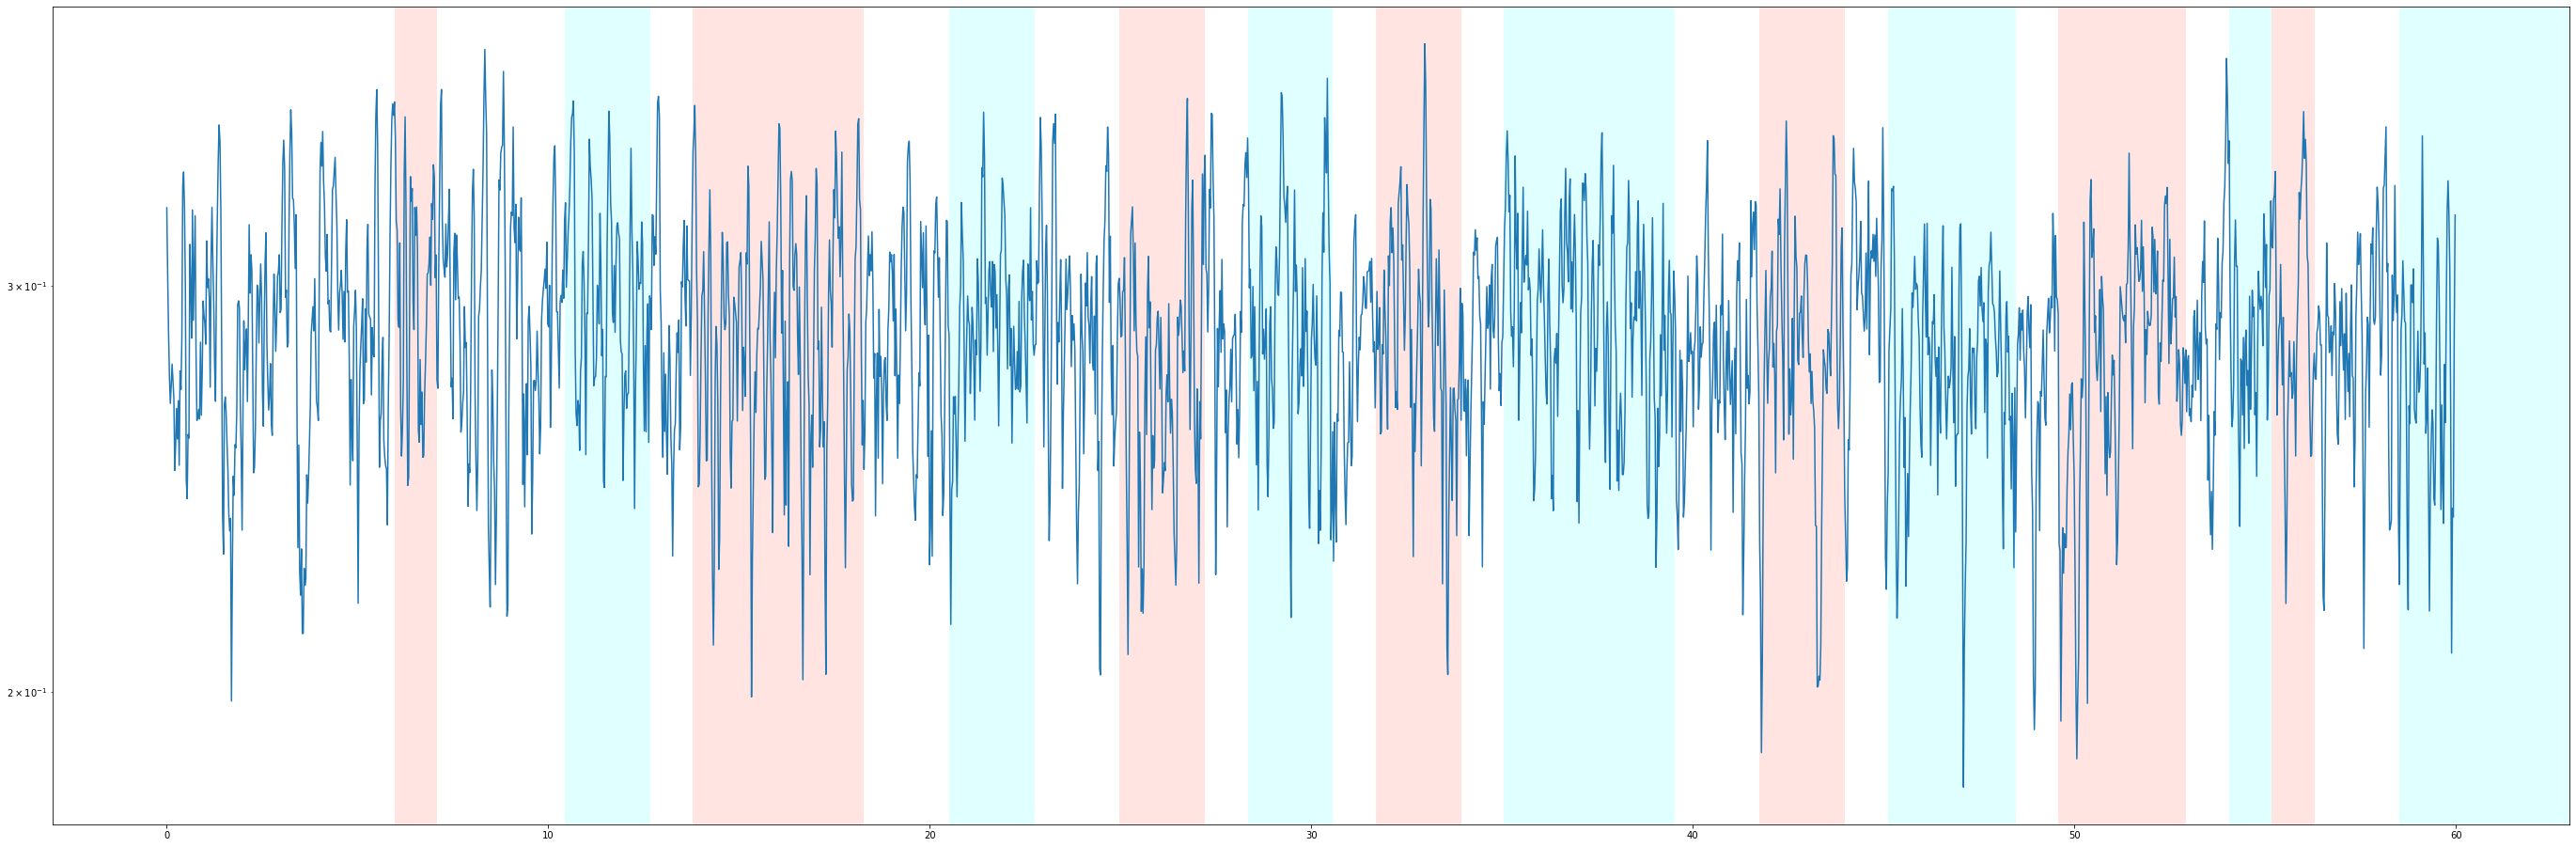

In [138]:
# Unter Berücksichtigung des gesamten Signals (sr Samples pro Sekunde => 22050 Samples pro Sekunde)
def show_RMS(y, sr, ind):
    rms = librosa.feature.rms(y = y)
    print(f'Länge des RMS: {len(rms[0])}')

    ax = plt.figure(figsize=(48, 16)).add_subplot()
    times = librosa.times_like(rms)
    ax.semilogy(times, rms[0], label='RMS Energy')
    change_curve_bgcolor(cr_list[ind], ax, 1, 14)
    plt.show()

execute_for_all(show_RMS)

function of show_RMS_Iterv for dataset of index 0


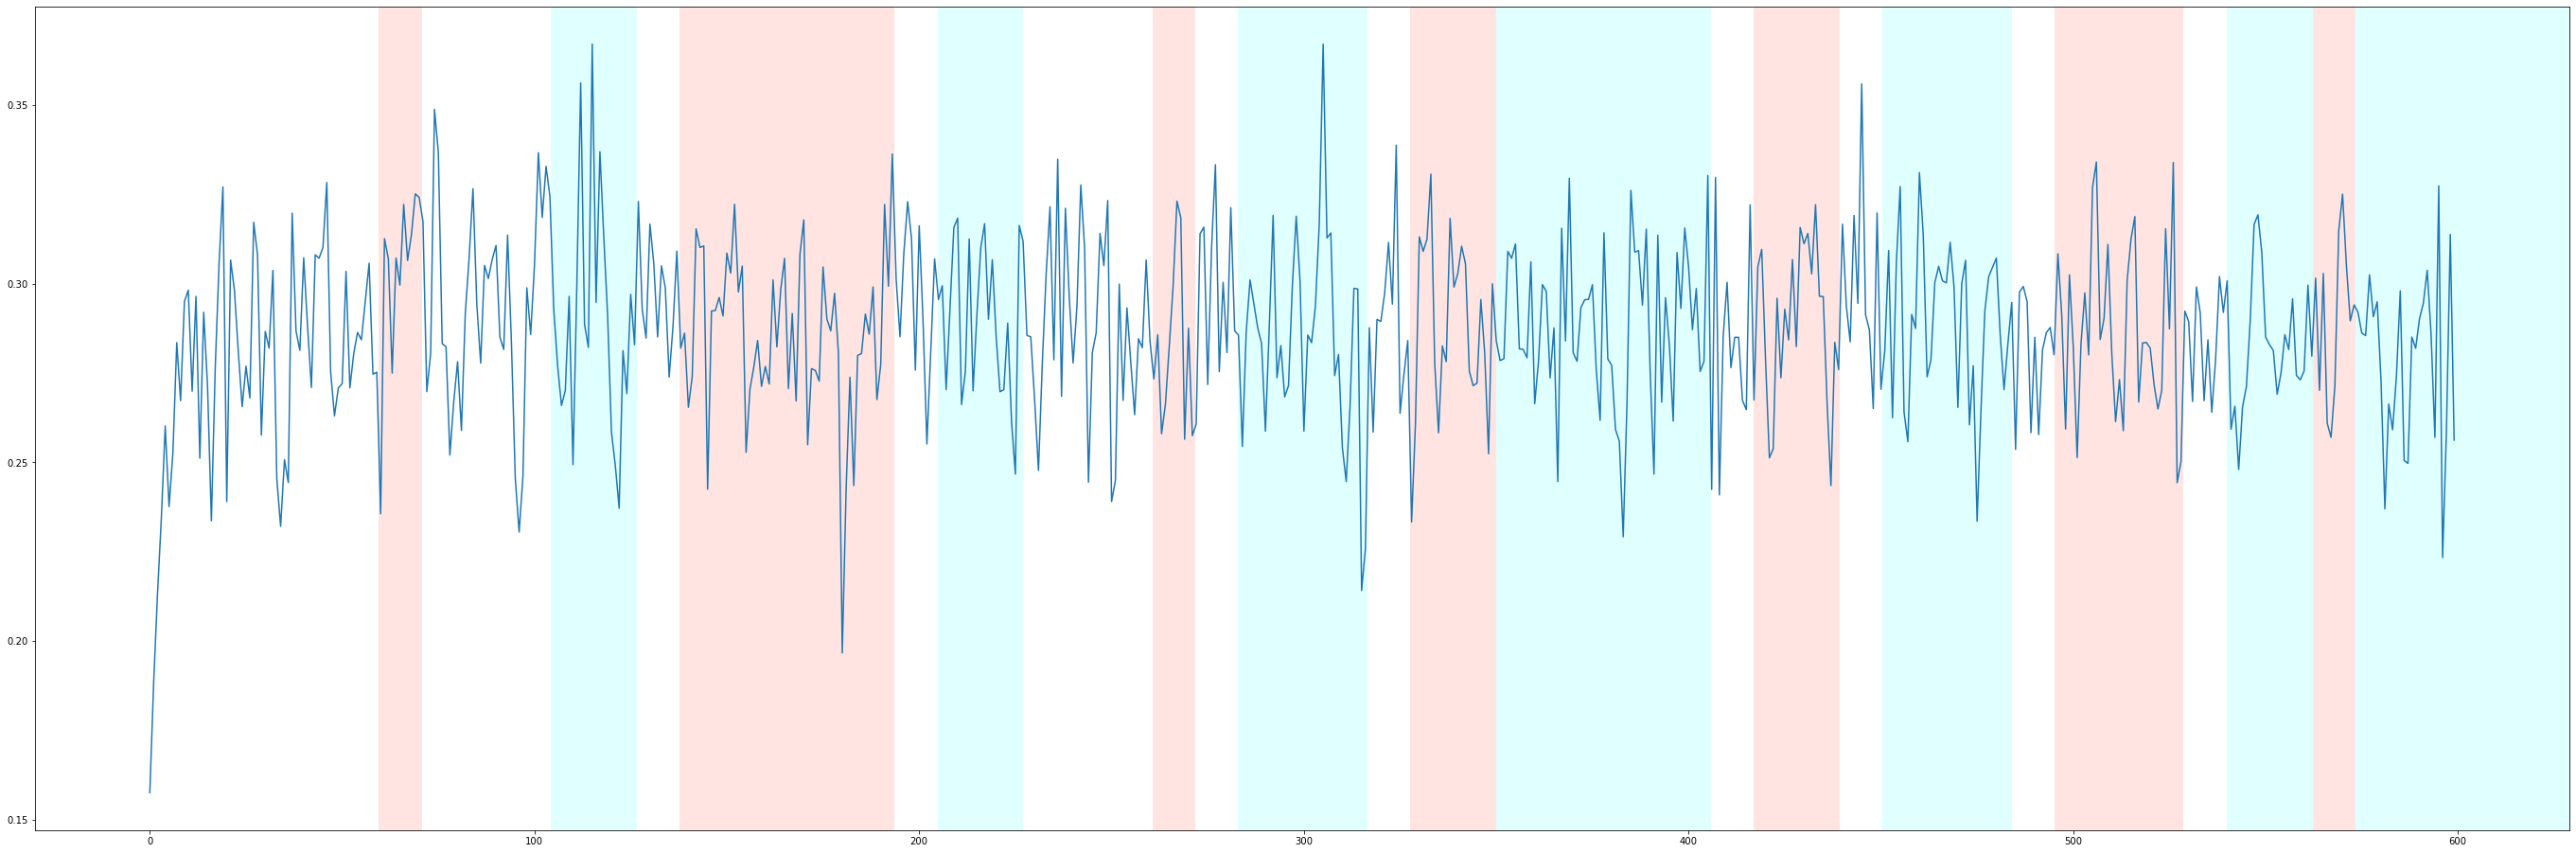

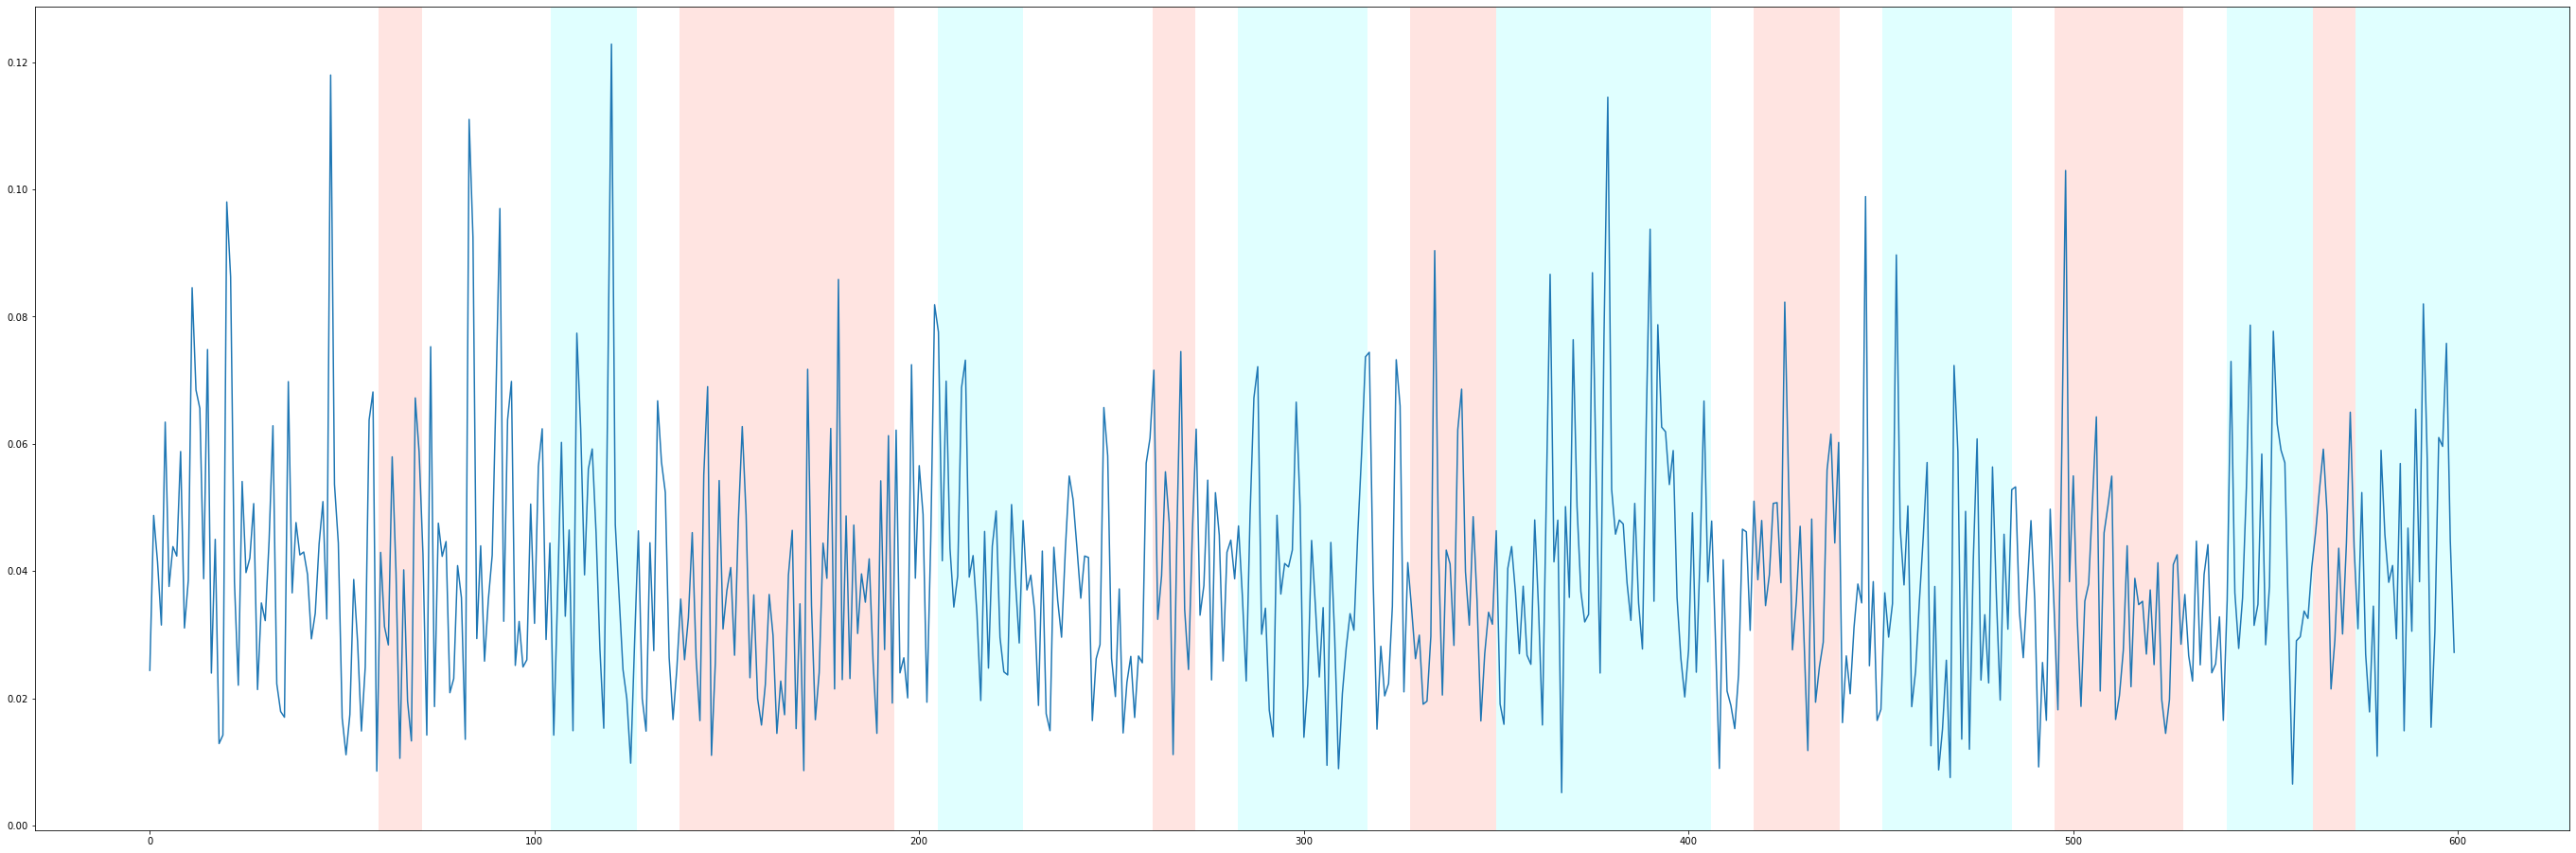

function of show_RMS_Iterv for dataset of index 1


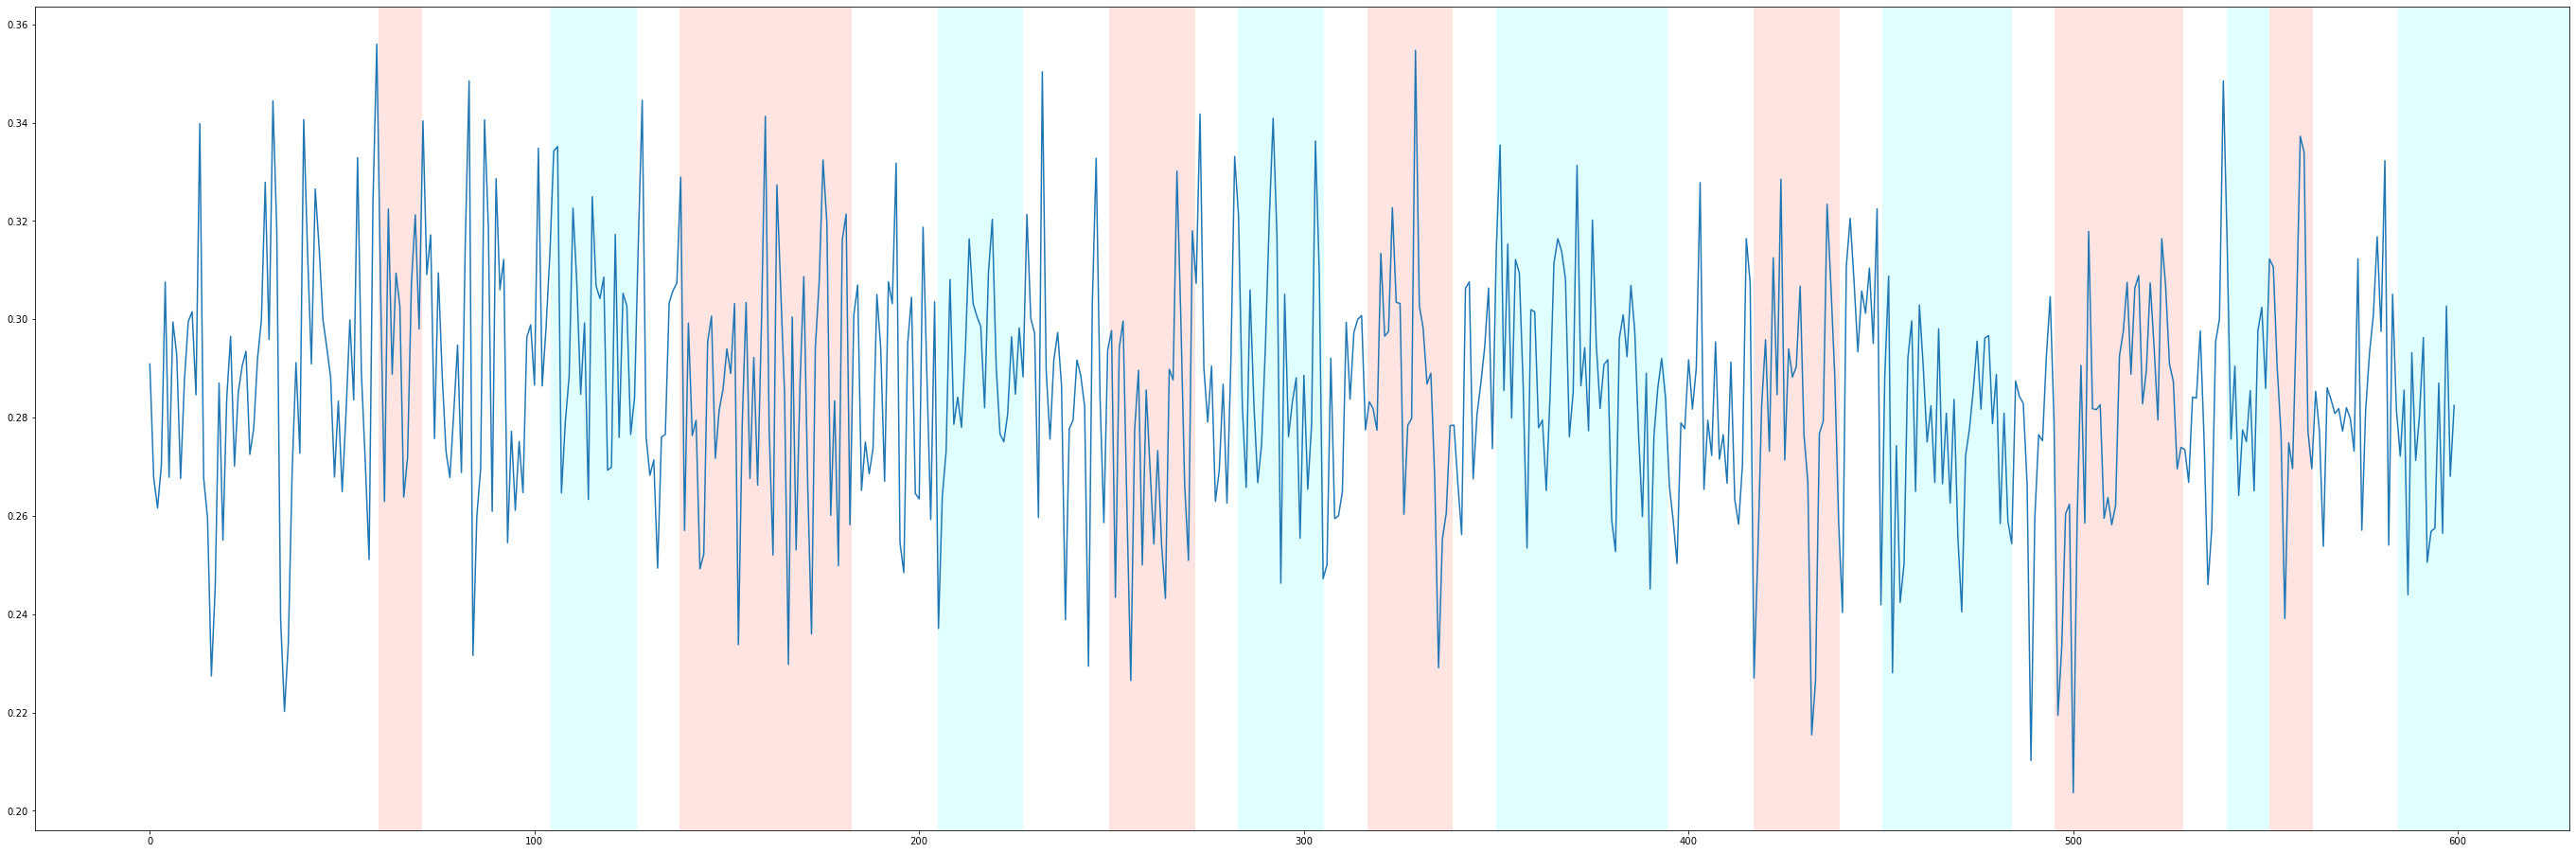

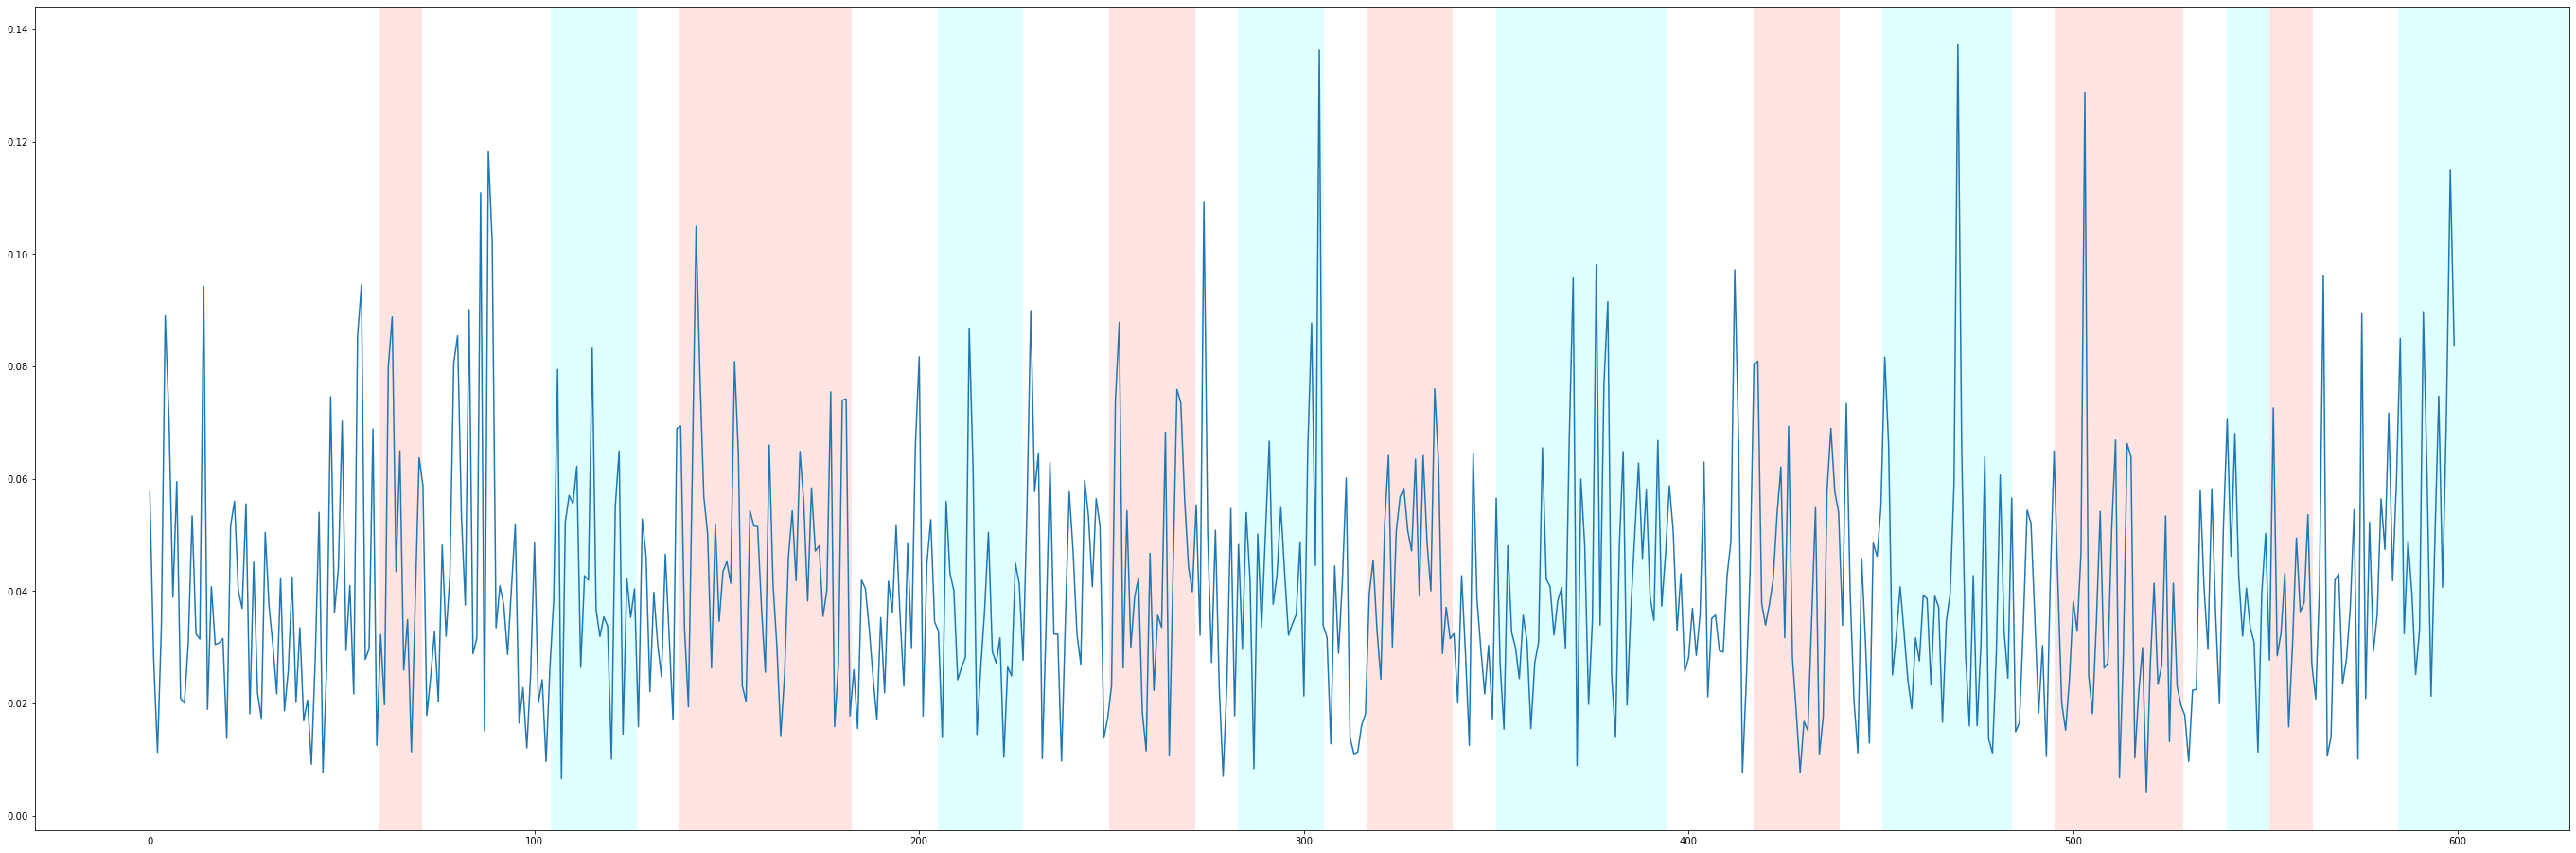

In [171]:
def show_RMS_Iterv(y, sr, ind):
    rms = librosa.feature.rms(y = y)

    interval = 0.1

    for ms in measures:
        rms_trans = transform_to_interval(rms[0], interval, ms[1])
        ax = plt.figure(figsize=(48, 16)).add_subplot()

        ax.plot(rms_trans, label=f'{ms[0]} RMS with interval of {interval} sec')
        change_curve_bgcolor(cr_list[ind], ax, interval, 14)
        plt.show()
    
execute_for_all(show_RMS_Iterv)

### Zero-Crossing-Rate
- Beobachtung der Änderung in der Amplitude
- Ergebnis mit den Datensätzen: Kein Muster erkenntbar

![](./doc/1_CMUnHjHi2OQY88VKA34PBQ.png)

function of show_ZCR for dataset of index 0
Shape:(1, 2584),  Länge des ZCR: 2584


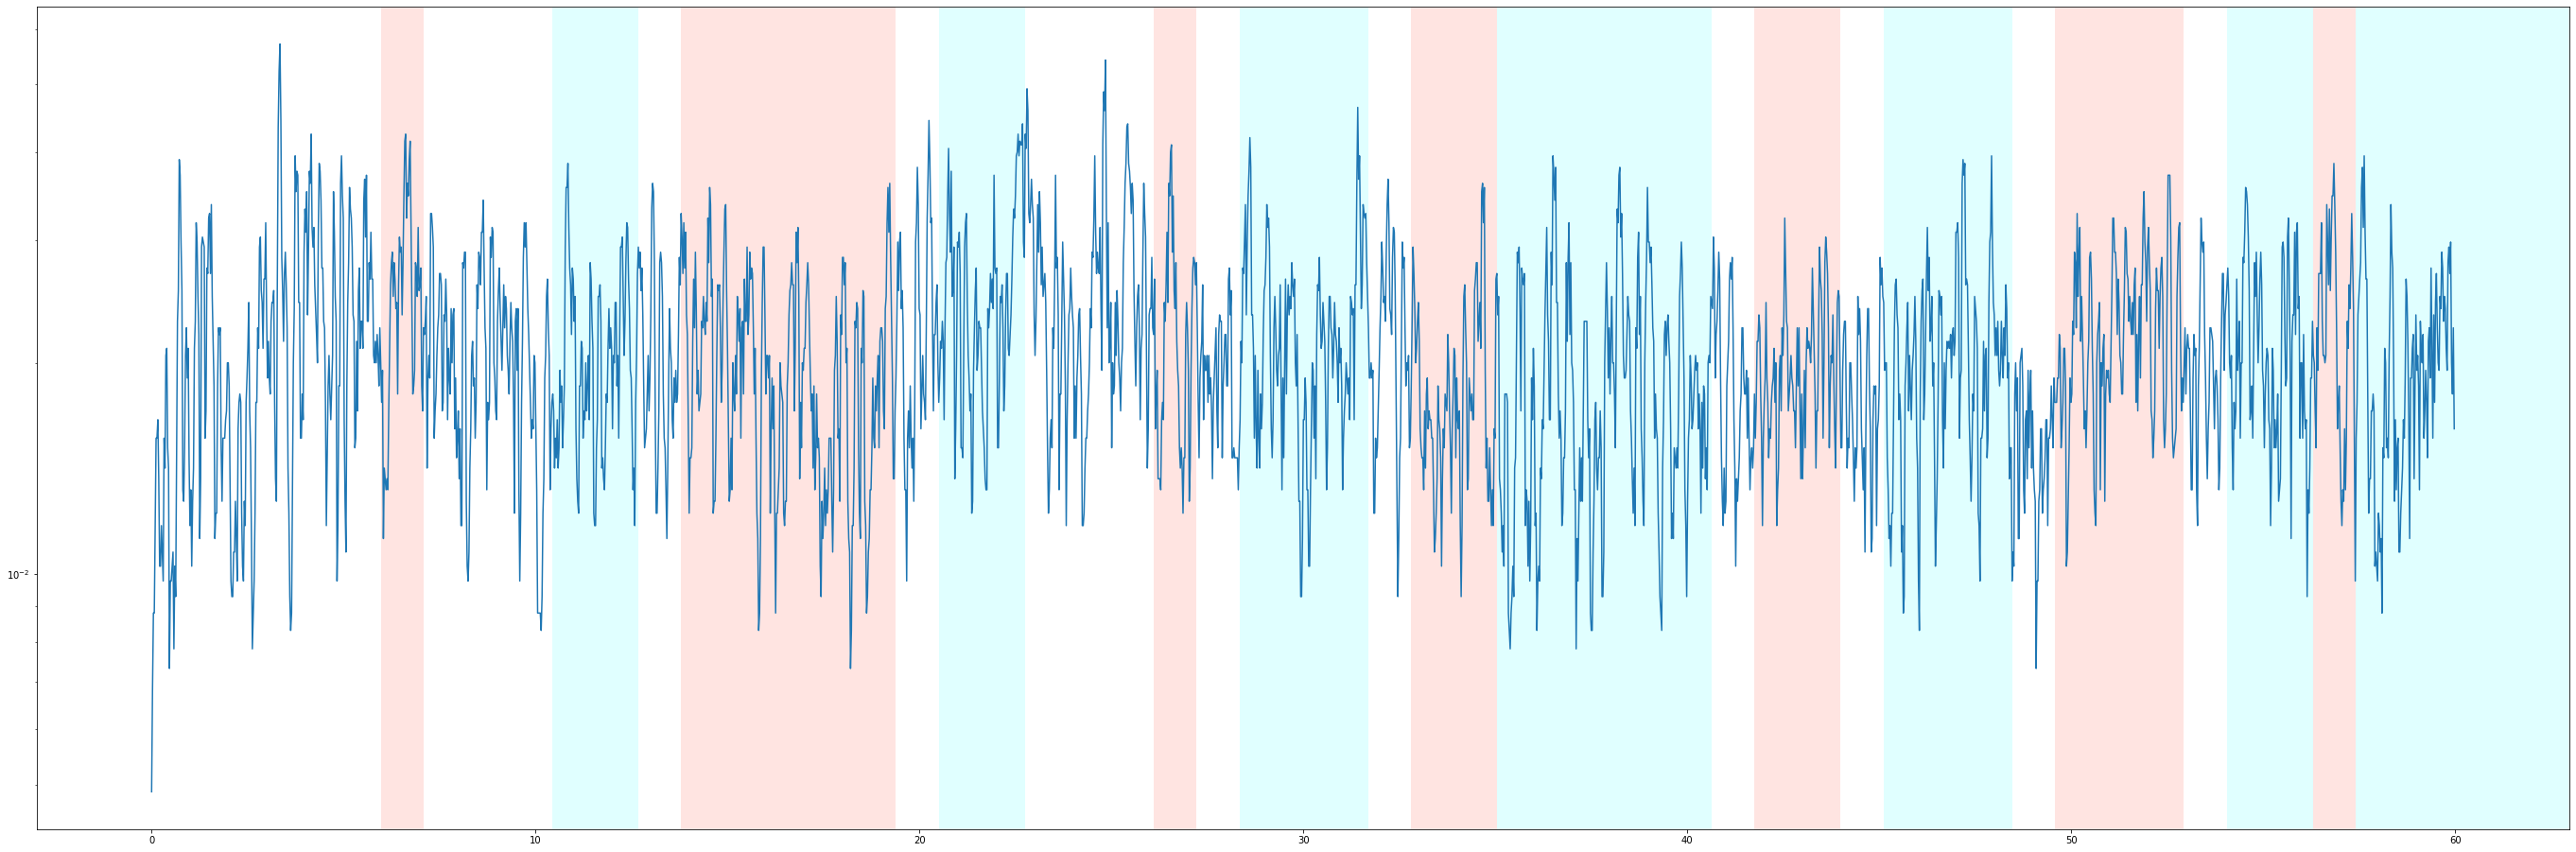

function of show_ZCR for dataset of index 1
Shape:(1, 2584),  Länge des ZCR: 2584


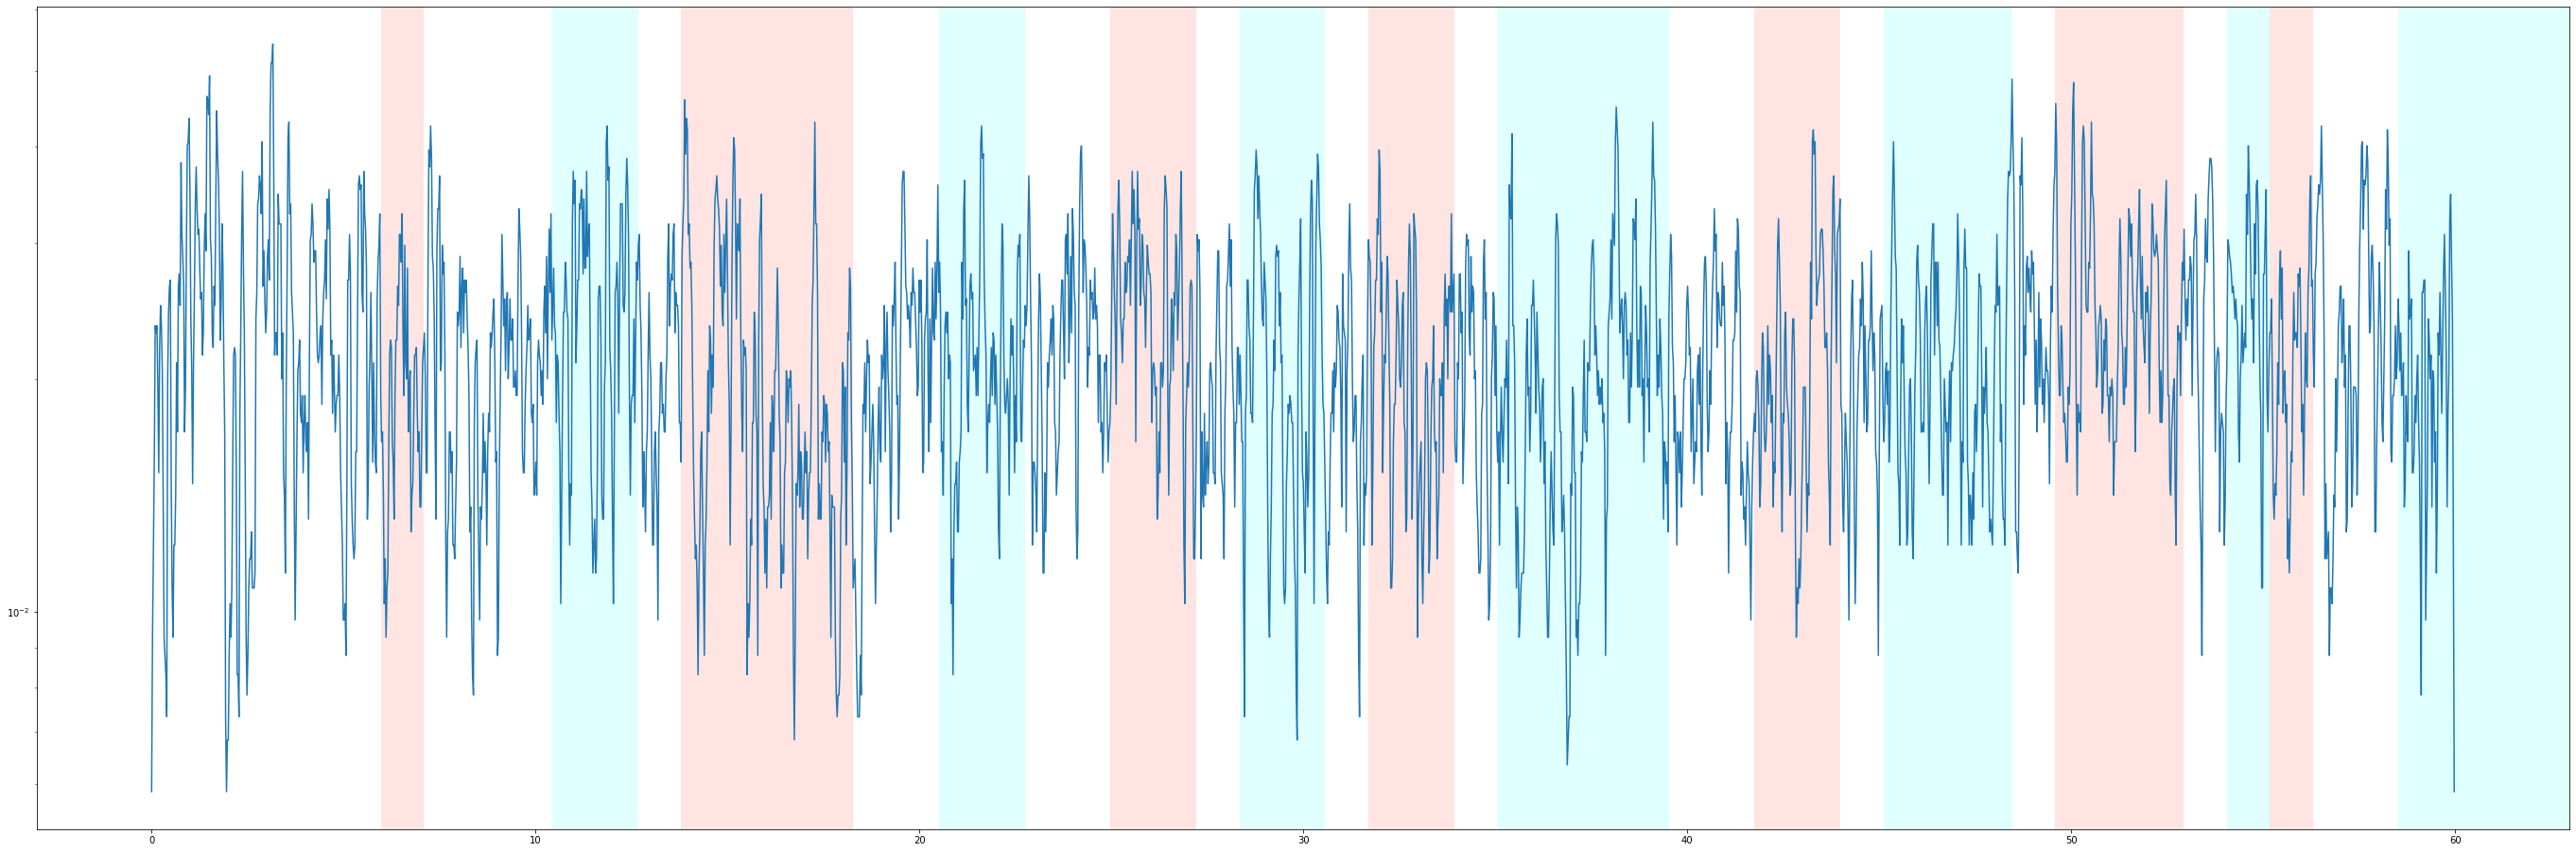

In [154]:
def show_ZCR(y, sr, ind):
    zcr = librosa.feature.zero_crossing_rate(y = y)
    print(f'Shape:{zcr.shape},  Länge des ZCR: {len(zcr[0])}')

    ax = plt.figure(figsize=(48, 16)).add_subplot()
    times = librosa.times_like(zcr)
    ax.semilogy(times, zcr[0], label='RMS Energy')
    change_curve_bgcolor(cr_list[ind], ax, 1, 14)

    plt.show()

execute_for_all(show_ZCR)

function of show_ZCR_Iterv for dataset of index 0


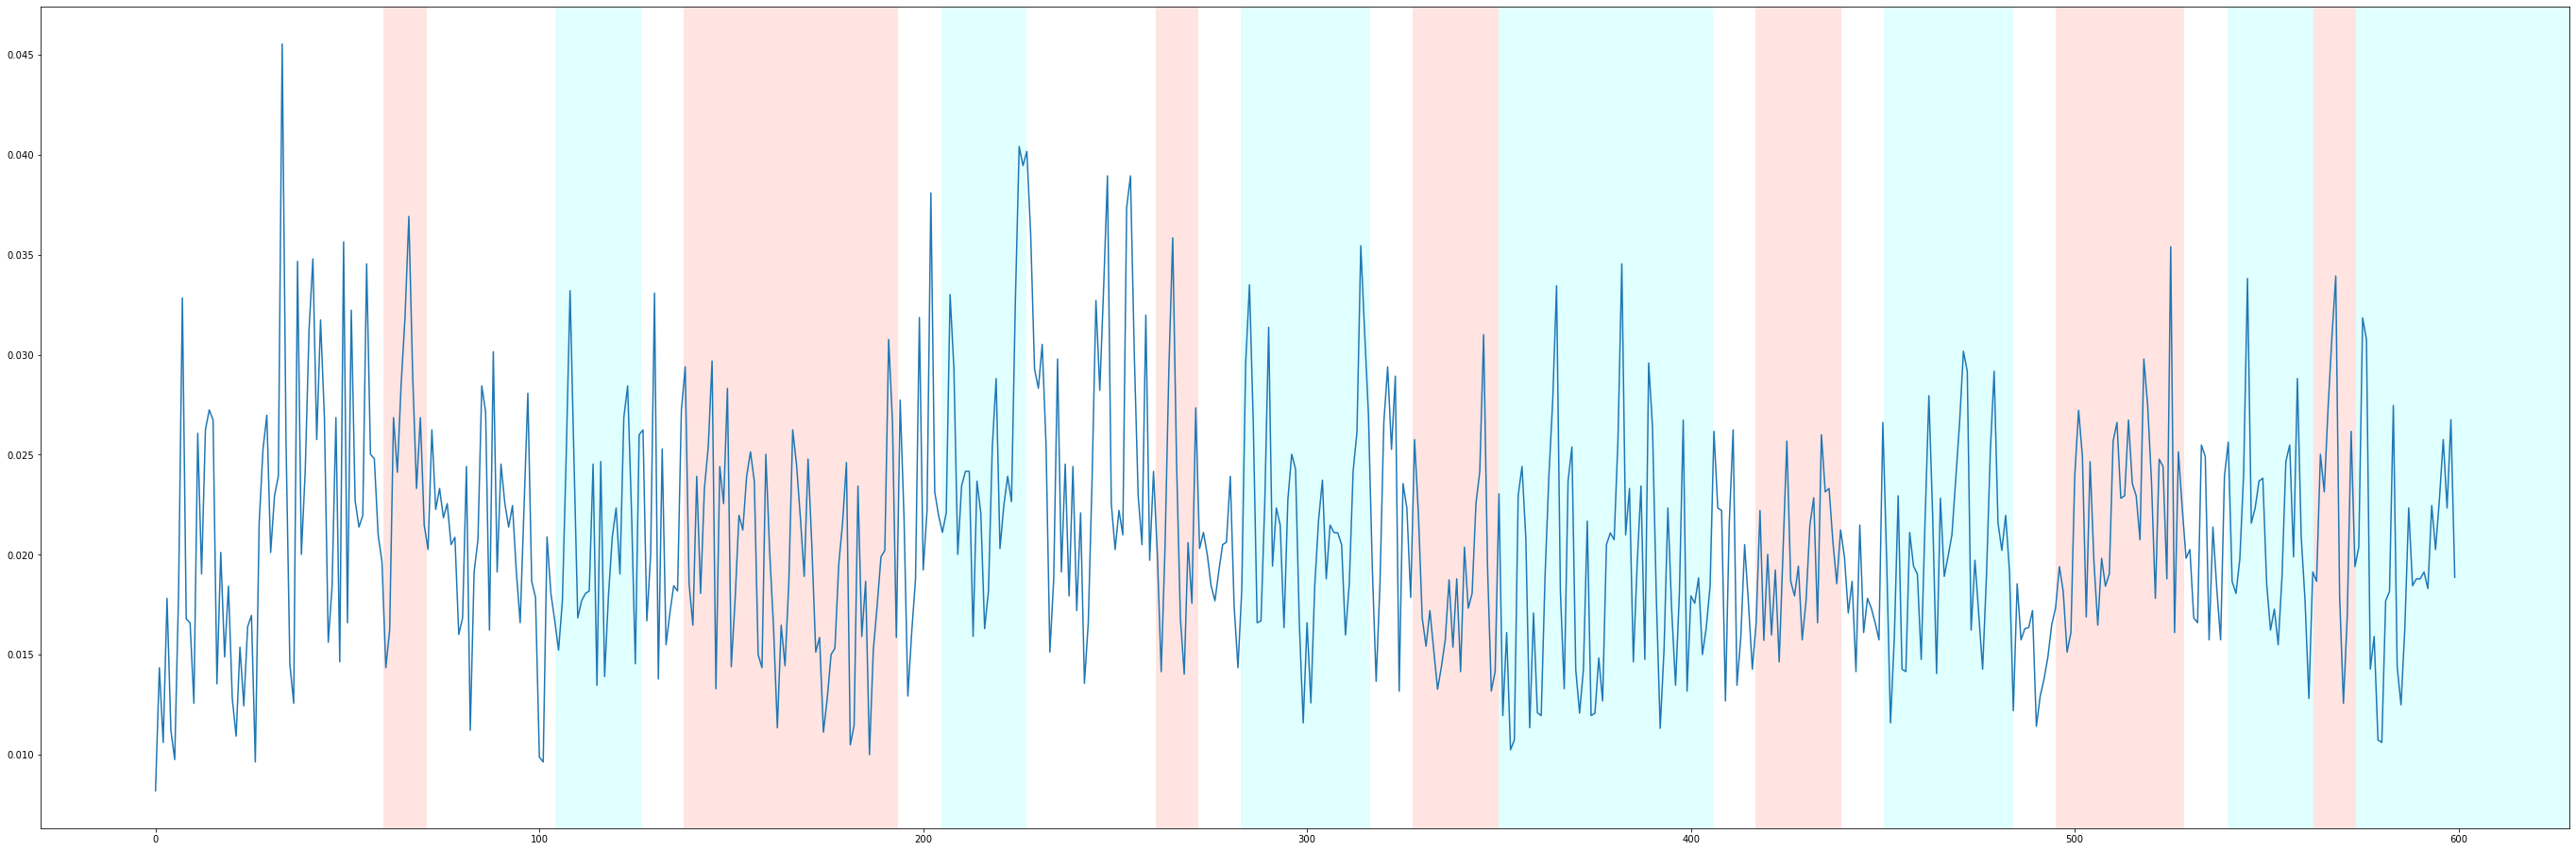

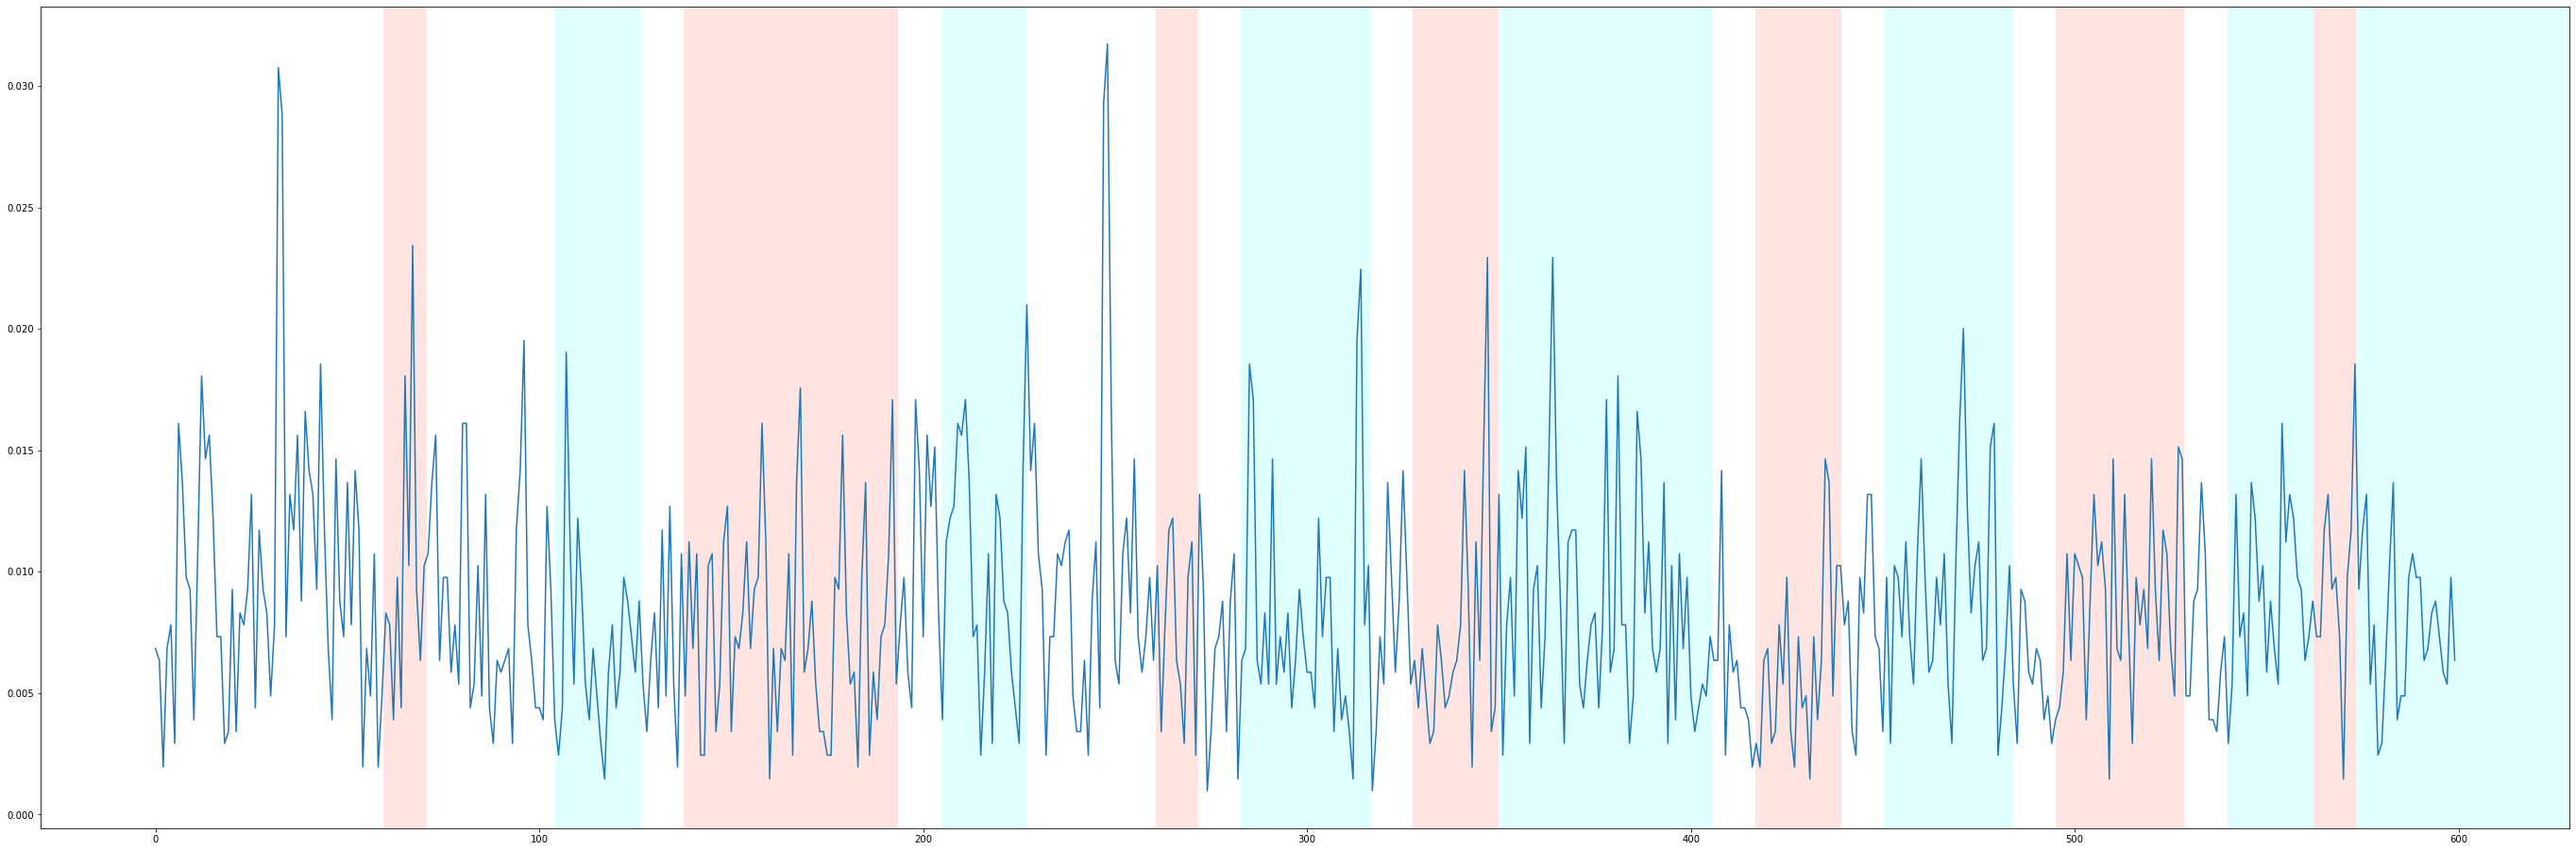

function of show_ZCR_Iterv for dataset of index 1


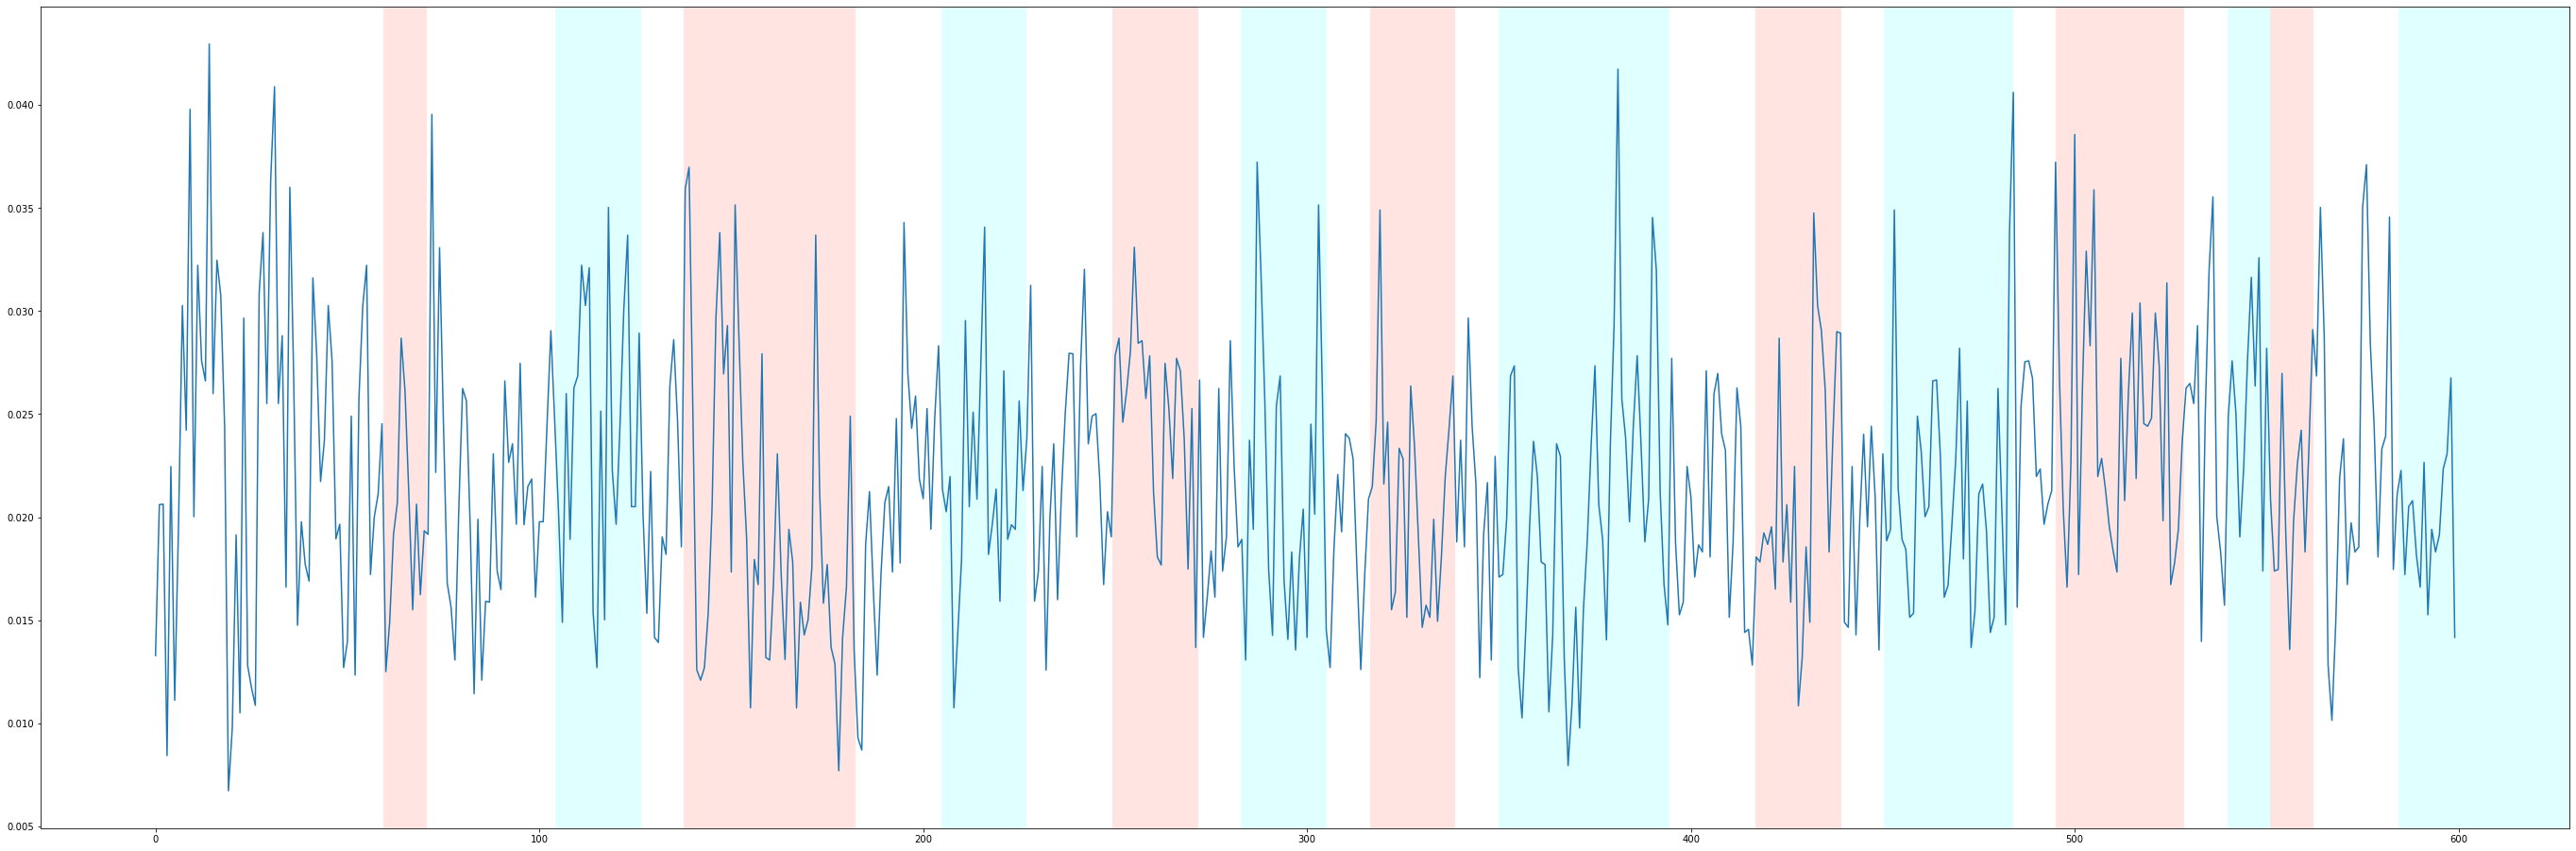

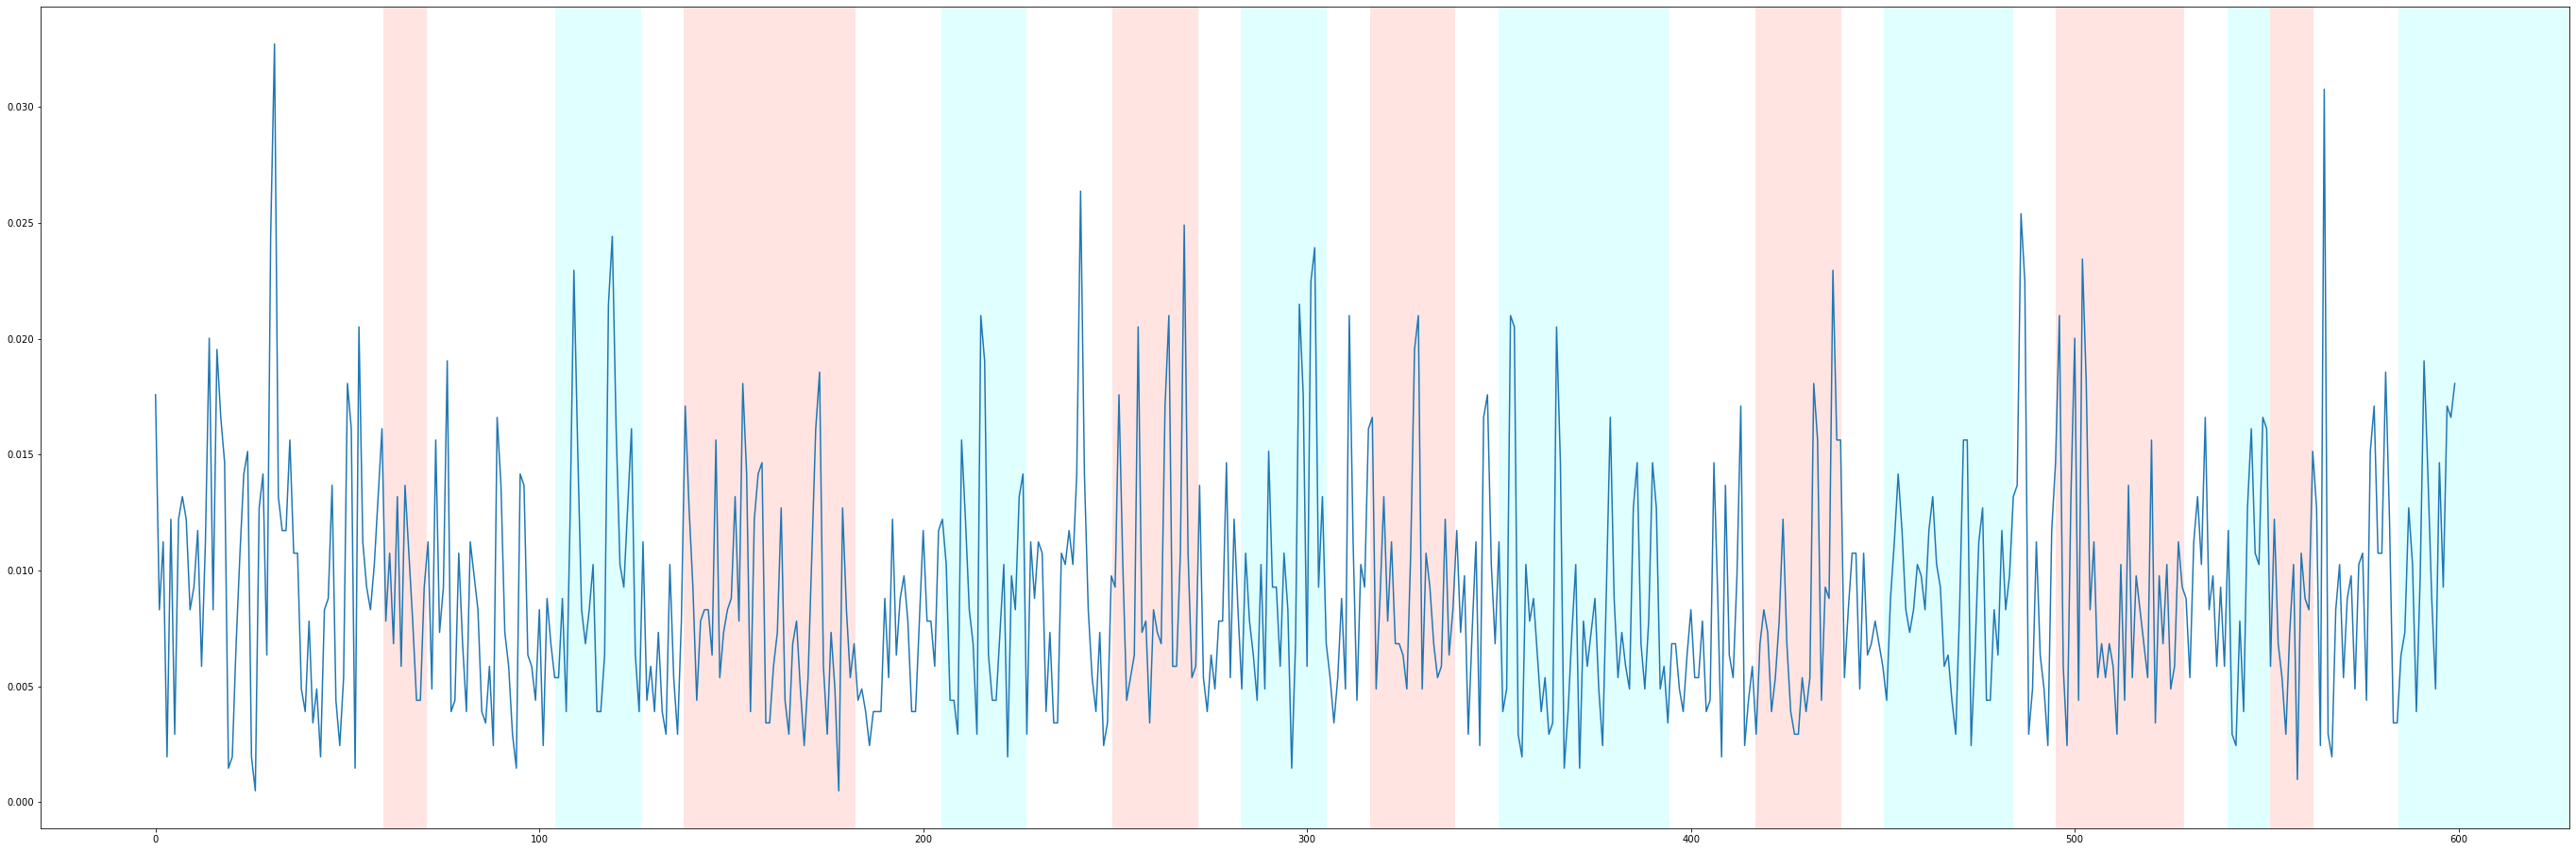

In [172]:
def show_ZCR_Iterv(y, sr, ind):
    zcr = librosa.feature.zero_crossing_rate(y = y)

    interval = 0.1

    for ms in measures:
        zcr_trans = transform_to_interval(zcr[0], interval, ms[1])
        
        ax = plt.figure(figsize=(48, 16)).add_subplot()

        ax.plot(zcr_trans, label='{ms[0]} ZCR with interval of {interval} sec')
        change_curve_bgcolor(cr_list[ind], ax, interval, 14)

        plt.show()

execute_for_all(show_ZCR_Iterv)

function of display_chroma for dataset of index 0
[slice(None, None, None), slice(0, 56976855, None)]
2584
2584
2584


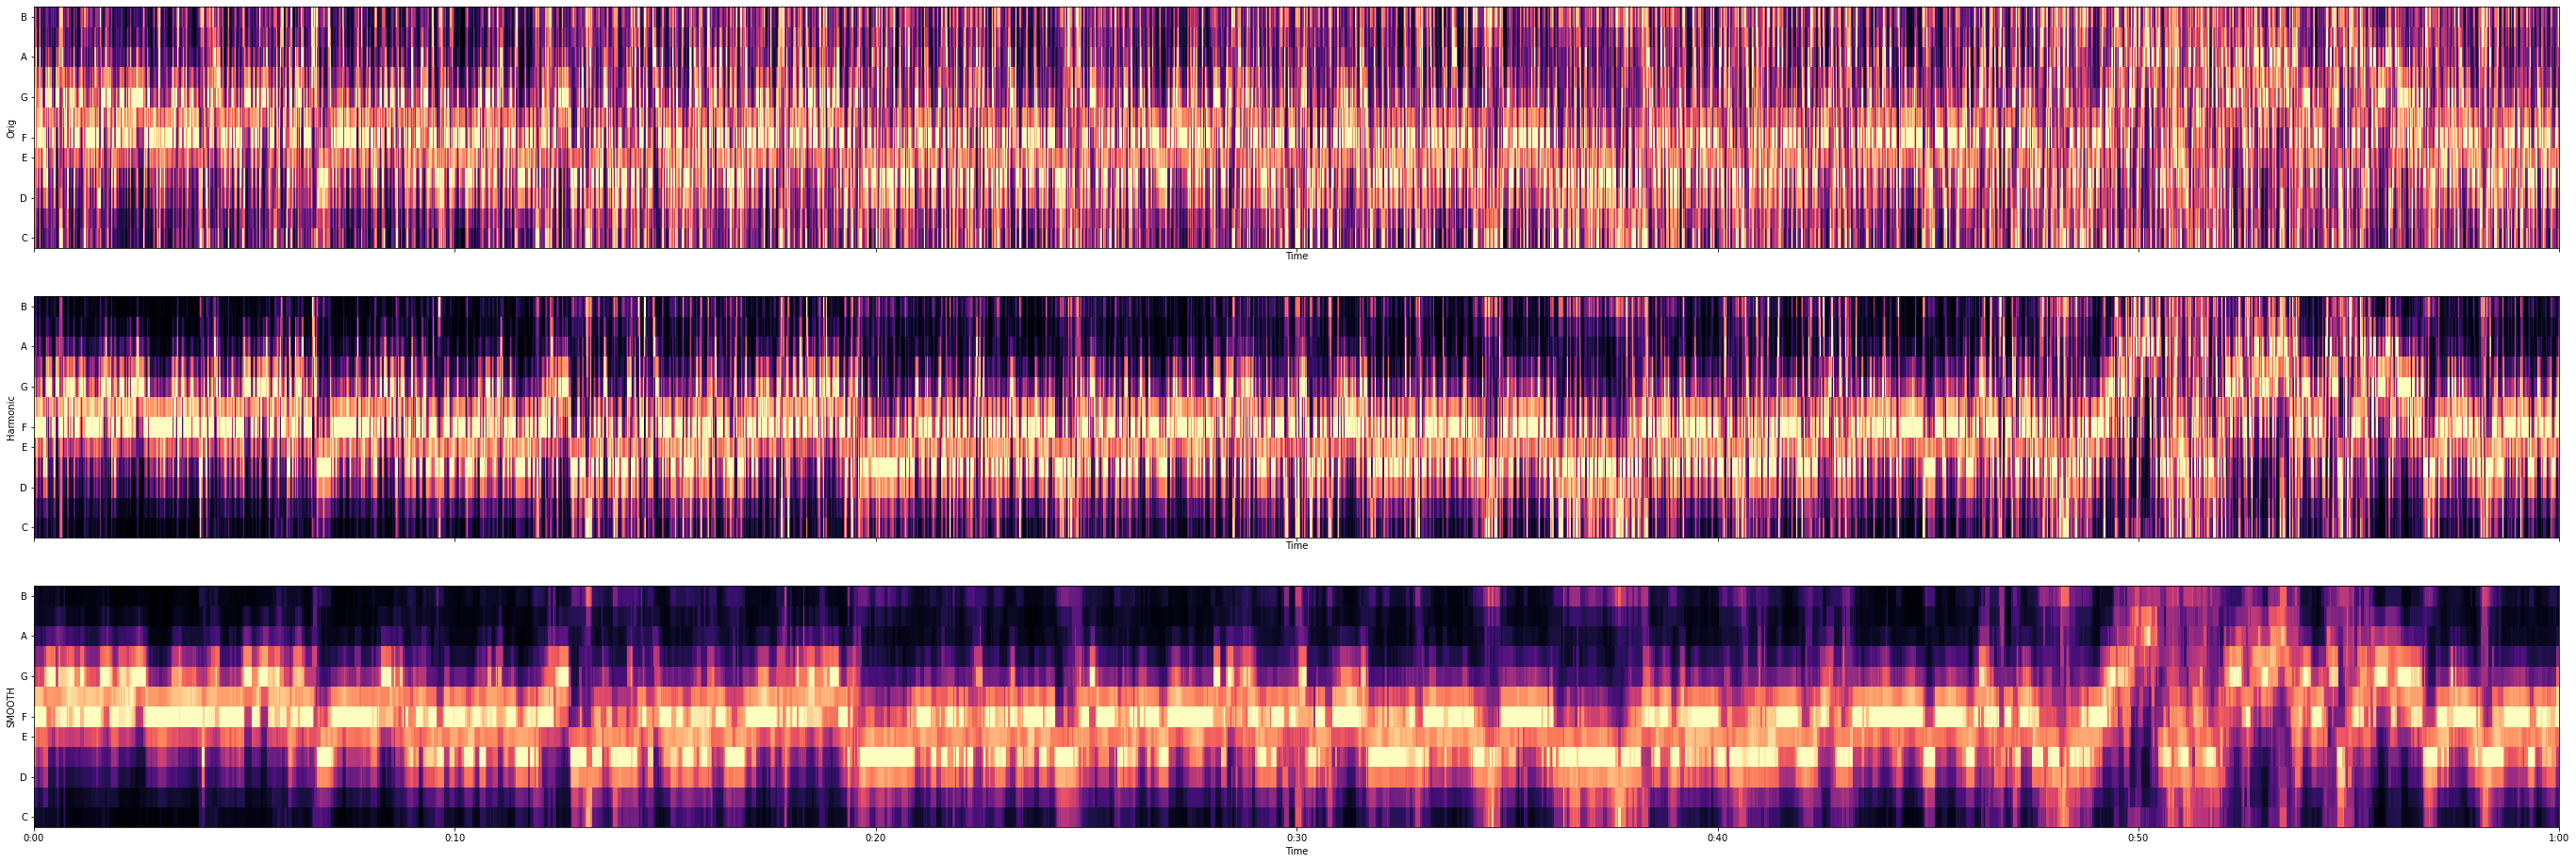

function of display_chroma for dataset of index 1
[slice(None, None, None), slice(0, 56976855, None)]
2584
2584
2584


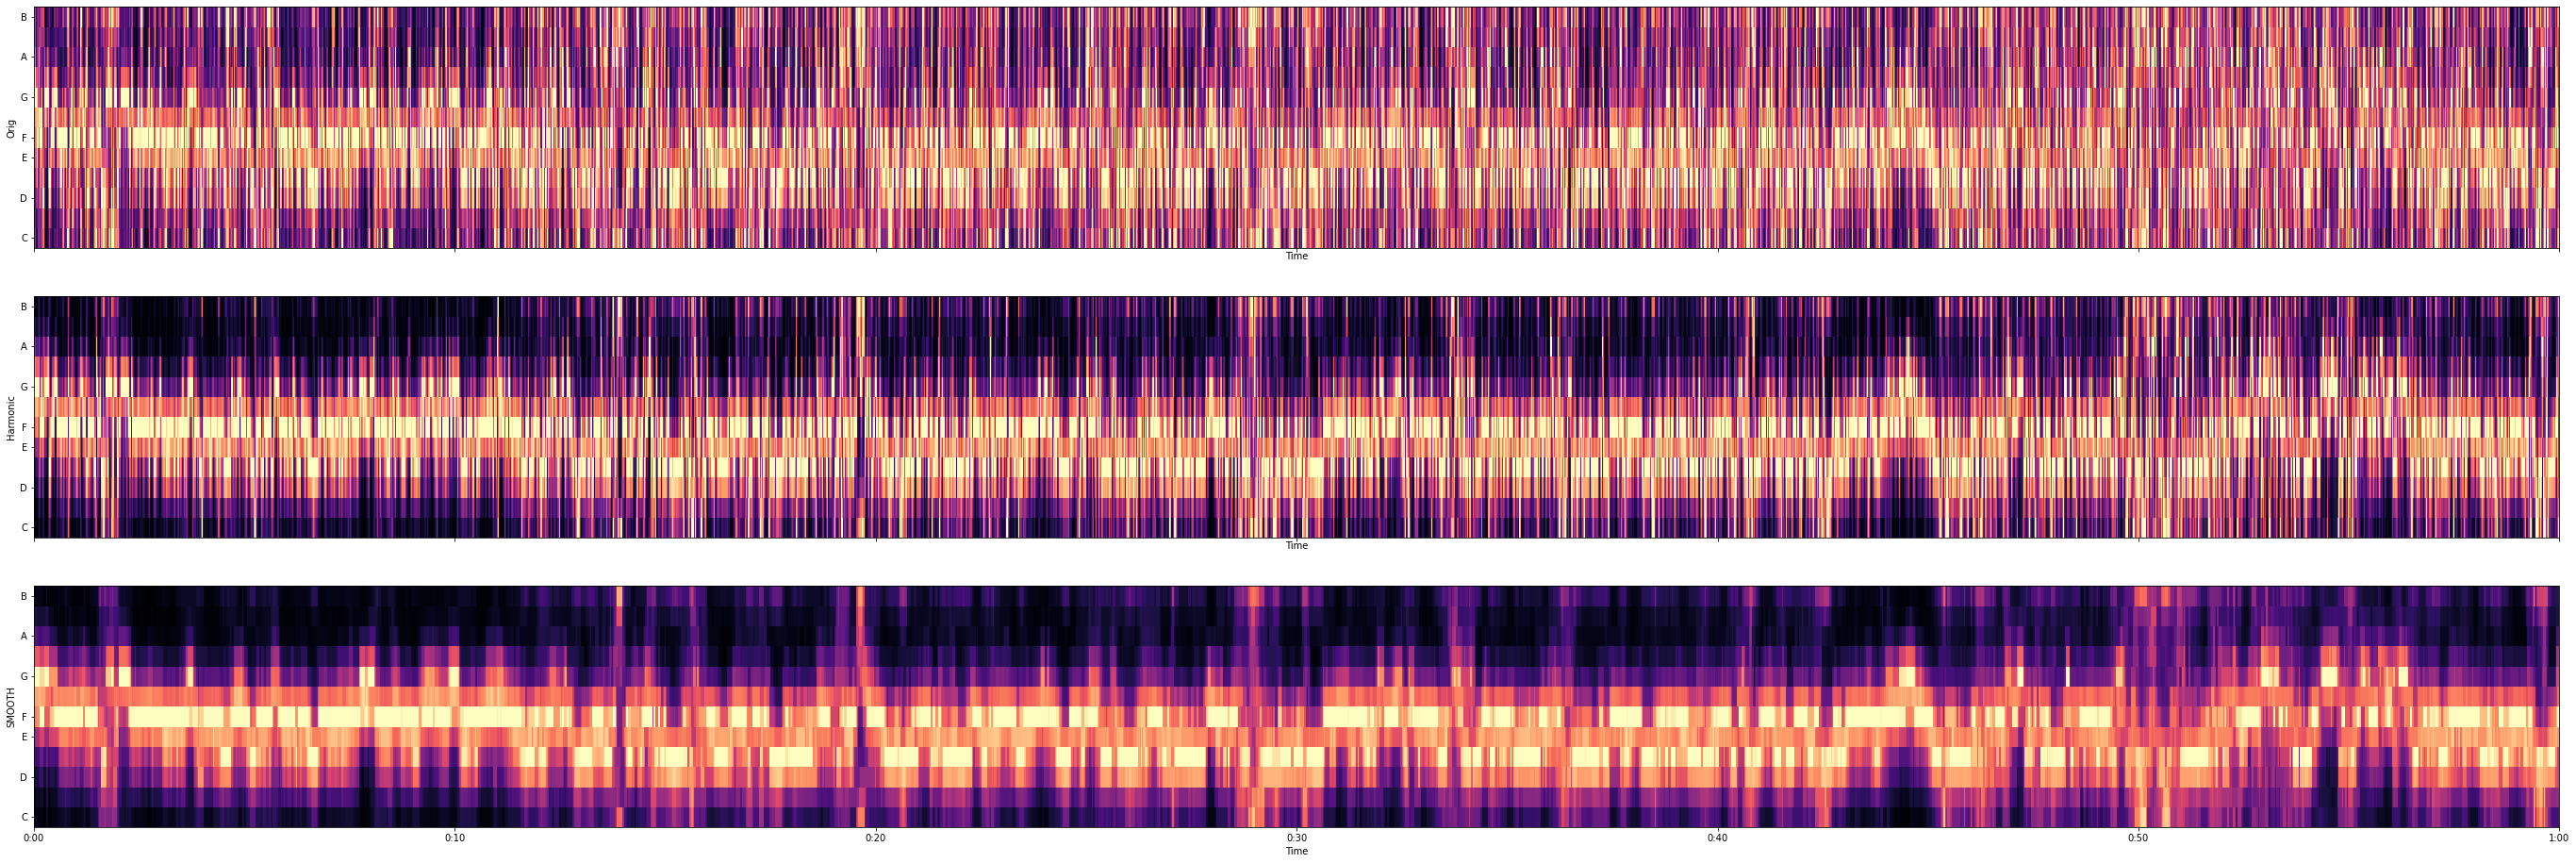

In [256]:
# 12 Pitch Classes (Tonklassen): C, C#, D, D#, E, F, F#, G, G#, A, A#, B
def display_chroma(y, sr, ind):
    idx = [slice(None), slice(*librosa.time_to_frames([0, len(y)]).tolist())]
    print(idx)
    chromagram_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    print(len(chromagram_stft[0]))

    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_harm = librosa.feature.chroma_stft(y=y_harm, sr=sr)
    print(len(chroma_harm[0]))

    chroma_filter = np.minimum(chroma_harm,
                            librosa.decompose.nn_filter(chroma_harm,
                                                        aggregate=np.median,
                                                        metric='cosine'))
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))
    print(len(chroma_smooth[0]))

    fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(48, 16))

    librosa.display.specshow(chromagram_stft, y_axis='chroma', x_axis='time', ax=ax[0])
    change_curve_bgcolor(cr_list[ind], ax[0], 1, 14, True)
    ax[0].set(ylabel='Orig')

    librosa.display.specshow(chroma_harm, y_axis='chroma', x_axis='time', ax=ax[1])
    ax[1].set(ylabel='Harmonic')

    librosa.display.specshow(chroma_smooth, y_axis='chroma', x_axis='time', ax=ax[2])
    ax[2].set(ylabel='SMOOTH')

    plt.show()

execute_for_all(display_chroma)

function of show_MAD_Chroma for dataset of index 0


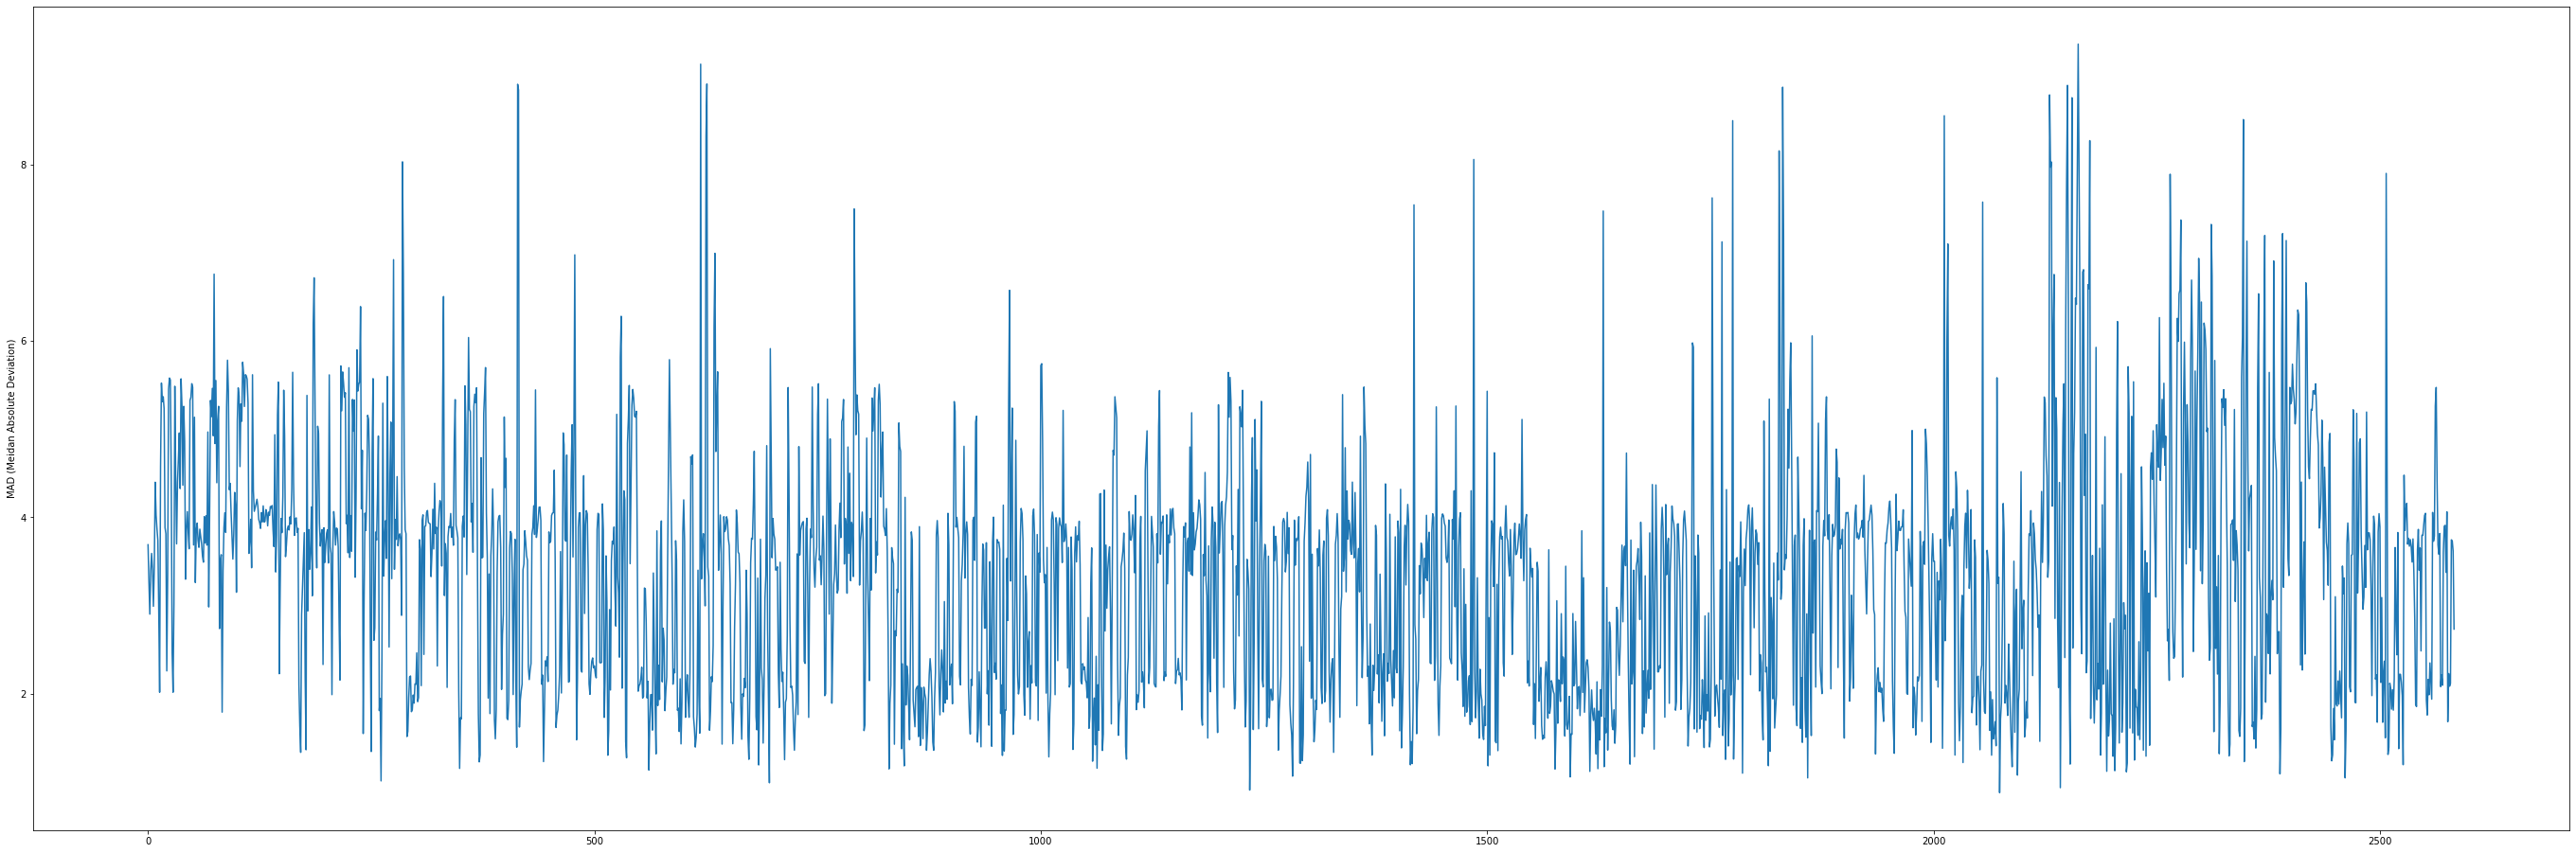

function of show_MAD_Chroma for dataset of index 1


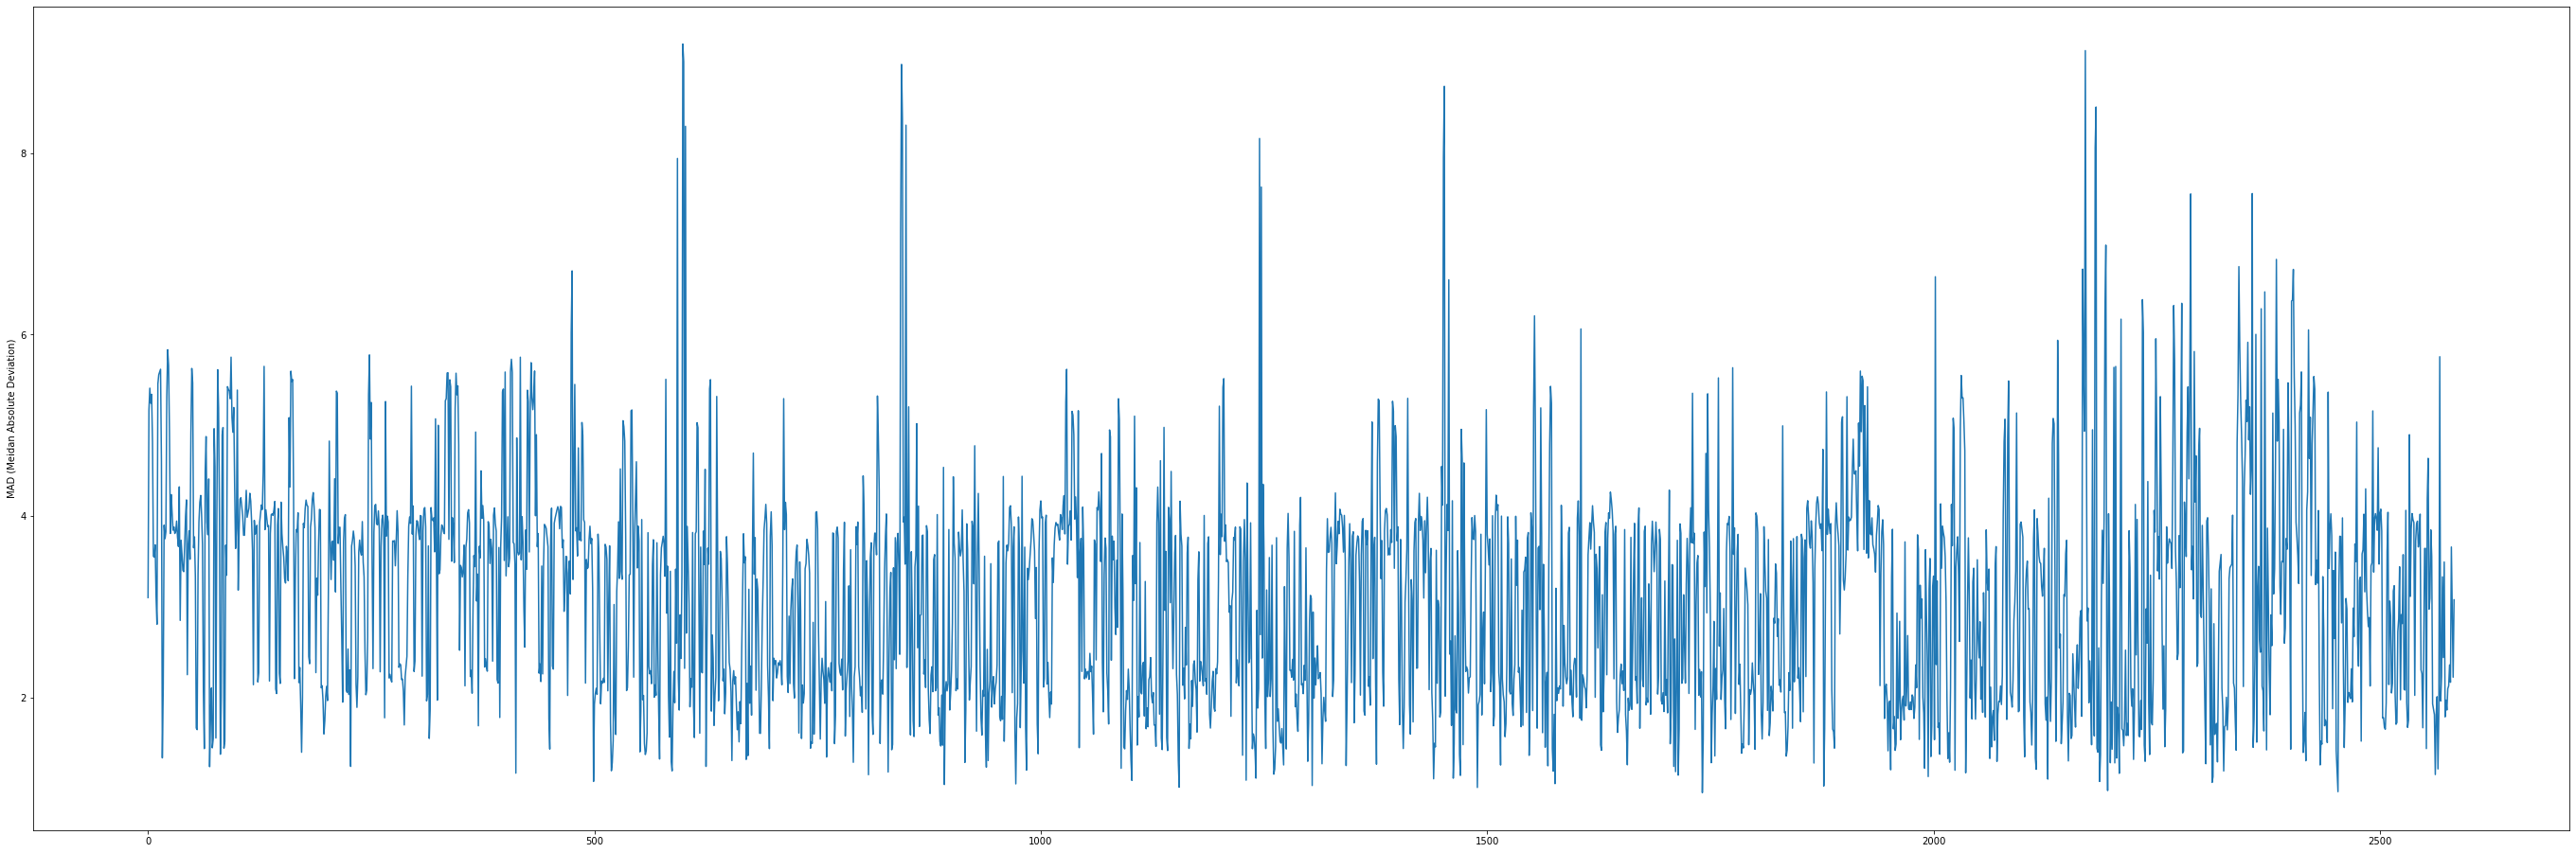

function of show_MAD_Chroma_Mean for dataset of index 0


In [303]:
# Median absolute deviation
def get_MAD(values, max_val, max_val_pc):
    median = max_val * max_val_pc
    subst_val = []
    for idx in range(len(values)):
        pc = idx + 1 
        pc_val = values[idx] * pc
        subst_val.append(abs(pc_val - median))

    return sum(subst_val) / len(subst_val)

def get_MAD_Chroma(y,sr):
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_harm = librosa.feature.chroma_stft(y=y_harm, sr=sr)
    chroma_filter = np.minimum(chroma_harm,
                        librosa.decompose.nn_filter(chroma_harm,
                                                    aggregate=np.median,
                                                    metric='cosine'))
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

    highest = []
    mads = []
    for t in range(len(chroma_harm[0])): # time
        temp_vals = [0] * 12
        pitch_class = 0
        highest_val = 0
        for pc in range(len(chroma_harm)): # pitch class
            temp_vals[pc] = chroma_harm[pc][t]
            current_val = chroma_harm[pc][t]
            if current_val > highest_val:
                highest_val = current_val
                pitch_class = pc + 1
        highest.append(pitch_class)

        mads.append(get_MAD(temp_vals, highest_val, pitch_class))
    
    return np.array(mads)

def show_MAD_Chroma(y, sr, ind):
    mads = get_MAD_Chroma(y, sr)
    
    ax = plt.figure(figsize=(48, 16)).add_subplot()
    ax.plot(mads)
    ax.set(ylabel='MAD (Meidan Absolute Deviation)')
    plt.show()

def show_MAD_Chroma_Mean(y,sr,ind):
    mads = get_MAD_Chroma(y, sr)

    ax = plt.figure(figsize=(48, 16)).add_subplot()

    mads_trans = transform_to_range_interval(mads, int(len(mads) / 60), np.mean)

    ax.plot(mads_trans)
    ax.set(ylabel='MAD (Meidan Absolute Deviation per Sec)')
    change_curve_bgcolor(cr_list[ind], ax, 1, 14)
    
    plt.show()

execute_for_all(show_MAD_Chroma)
execute_for_all(show_MAD_Chroma_Mean)